In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3312053, 828)
(3312053, 8)
validation
(477757, 828)
(477757, 8)
test
(427942, 828)
(427942, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/332 [..............................] - ETA: 7:12 - loss: 2.2979 - STD: 0.0785 - MAE: 0.2192

  4/332 [..............................] - ETA: 5s - loss: 2.1389 - STD: 0.0518 - MAE: 0.2174  

  7/332 [..............................] - ETA: 5s - loss: 2.1171 - STD: 0.0520 - MAE: 0.2168

 10/332 [..............................] - ETA: 5s - loss: 2.1056 - STD: 0.0511 - MAE: 0.2166

 13/332 [>.............................] - ETA: 5s - loss: 2.0940 - STD: 0.0486 - MAE: 0.2165

 17/332 [>.............................] - ETA: 5s - loss: 2.0843 - STD: 0.0439 - MAE: 0.2166

 21/332 [>.............................] - ETA: 5s - loss: 2.0783 - STD: 0.0410 - MAE: 0.2167

 25/332 [=>............................] - ETA: 5s - loss: 2.0717 - STD: 0.0398 - MAE: 0.2166

 28/332 [=>............................] - ETA: 5s - loss: 2.0672 - STD: 0.0394 - MAE: 0.2165

 32/332 [=>............................] - ETA: 5s - loss: 2.0601 - STD: 0.0394 - MAE: 0.2162

 36/332 [==>...........................] - ETA: 4s - loss: 2.0509 - STD: 0.0396 - MAE: 0.2159

 40/332 [==>...........................] - ETA: 4s - loss: 2.0404 - STD: 0.0404 - MAE: 0.2155

 44/332 [==>...........................] - ETA: 4s - loss: 2.0284 - STD: 0.0419 - MAE: 0.2150

 48/332 [===>..........................] - ETA: 4s - loss: 2.0154 - STD: 0.0439 - MAE: 0.2143

 52/332 [===>..........................] - ETA: 4s - loss: 2.0024 - STD: 0.0461 - MAE: 0.2137

 56/332 [====>.........................] - ETA: 4s - loss: 1.9891 - STD: 0.0484 - MAE: 0.2130

 60/332 [====>.........................] - ETA: 4s - loss: 1.9749 - STD: 0.0506 - MAE: 0.2122

 64/332 [====>.........................] - ETA: 4s - loss: 1.9597 - STD: 0.0529 - MAE: 0.2114

 68/332 [=====>........................] - ETA: 4s - loss: 1.9422 - STD: 0.0551 - MAE: 0.2106

 72/332 [=====>........................] - ETA: 4s - loss: 1.9238 - STD: 0.0578 - MAE: 0.2095

 76/332 [=====>........................] - ETA: 4s - loss: 1.9050 - STD: 0.0605 - MAE: 0.2085

 80/332 [======>.......................] - ETA: 4s - loss: 1.8865 - STD: 0.0634 - MAE: 0.2074

 84/332 [======>.......................] - ETA: 4s - loss: 1.8686 - STD: 0.0663 - MAE: 0.2063

 88/332 [======>.......................] - ETA: 3s - loss: 1.8517 - STD: 0.0691 - MAE: 0.2052

 92/332 [=======>......................] - ETA: 3s - loss: 1.8354 - STD: 0.0718 - MAE: 0.2041

 95/332 [=======>......................] - ETA: 3s - loss: 1.8233 - STD: 0.0737 - MAE: 0.2033

 99/332 [=======>......................] - ETA: 3s - loss: 1.8081 - STD: 0.0763 - MAE: 0.2023

103/332 [========>.....................] - ETA: 3s - loss: 1.7936 - STD: 0.0786 - MAE: 0.2013

107/332 [========>.....................] - ETA: 3s - loss: 1.7799 - STD: 0.0810 - MAE: 0.2004

110/332 [========>.....................] - ETA: 3s - loss: 1.7700 - STD: 0.0827 - MAE: 0.1997

113/332 [=========>....................] - ETA: 3s - loss: 1.7606 - STD: 0.0843 - MAE: 0.1990

116/332 [=========>....................] - ETA: 3s - loss: 1.7513 - STD: 0.0860 - MAE: 0.1983

119/332 [=========>....................] - ETA: 3s - loss: 1.7423 - STD: 0.0875 - MAE: 0.1976

123/332 [==========>...................] - ETA: 3s - loss: 1.7309 - STD: 0.0895 - MAE: 0.1968

127/332 [==========>...................] - ETA: 3s - loss: 1.7201 - STD: 0.0914 - MAE: 0.1960

131/332 [==========>...................] - ETA: 3s - loss: 1.7097 - STD: 0.0932 - MAE: 0.1952

135/332 [===========>..................] - ETA: 3s - loss: 1.6997 - STD: 0.0950 - MAE: 0.1945

139/332 [===========>..................] - ETA: 3s - loss: 1.6900 - STD: 0.0967 - MAE: 0.1938

143/332 [===========>..................] - ETA: 3s - loss: 1.6807 - STD: 0.0983 - MAE: 0.1931

146/332 [============>.................] - ETA: 3s - loss: 1.6741 - STD: 0.0995 - MAE: 0.1925

150/332 [============>.................] - ETA: 2s - loss: 1.6656 - STD: 0.1010 - MAE: 0.1919

154/332 [============>.................] - ETA: 2s - loss: 1.6572 - STD: 0.1024 - MAE: 0.1912

158/332 [=============>................] - ETA: 2s - loss: 1.6494 - STD: 0.1039 - MAE: 0.1906

161/332 [=============>................] - ETA: 2s - loss: 1.6435 - STD: 0.1049 - MAE: 0.1902

165/332 [=============>................] - ETA: 2s - loss: 1.6362 - STD: 0.1062 - MAE: 0.1896

168/332 [==============>...............] - ETA: 2s - loss: 1.6306 - STD: 0.1071 - MAE: 0.1892

172/332 [==============>...............] - ETA: 2s - loss: 1.6236 - STD: 0.1083 - MAE: 0.1886

176/332 [==============>...............] - ETA: 2s - loss: 1.6169 - STD: 0.1095 - MAE: 0.1881

180/332 [===============>..............] - ETA: 2s - loss: 1.6102 - STD: 0.1107 - MAE: 0.1876

183/332 [===============>..............] - ETA: 2s - loss: 1.6051 - STD: 0.1115 - MAE: 0.1872

187/332 [===============>..............] - ETA: 2s - loss: 1.5989 - STD: 0.1126 - MAE: 0.1867

191/332 [================>.............] - ETA: 2s - loss: 1.5928 - STD: 0.1137 - MAE: 0.1862

195/332 [================>.............] - ETA: 2s - loss: 1.5868 - STD: 0.1147 - MAE: 0.1857

199/332 [================>.............] - ETA: 2s - loss: 1.5810 - STD: 0.1158 - MAE: 0.1852

203/332 [=================>............] - ETA: 2s - loss: 1.5753 - STD: 0.1168 - MAE: 0.1848

207/332 [=================>............] - ETA: 2s - loss: 1.5697 - STD: 0.1177 - MAE: 0.1843

211/332 [==================>...........] - ETA: 1s - loss: 1.5642 - STD: 0.1187 - MAE: 0.1839

215/332 [==================>...........] - ETA: 1s - loss: 1.5590 - STD: 0.1196 - MAE: 0.1834

219/332 [==================>...........] - ETA: 1s - loss: 1.5537 - STD: 0.1205 - MAE: 0.1830

223/332 [===================>..........] - ETA: 1s - loss: 1.5488 - STD: 0.1214 - MAE: 0.1826

227/332 [===================>..........] - ETA: 1s - loss: 1.5441 - STD: 0.1223 - MAE: 0.1822

231/332 [===================>..........] - ETA: 1s - loss: 1.5393 - STD: 0.1231 - MAE: 0.1818

235/332 [====================>.........] - ETA: 1s - loss: 1.5347 - STD: 0.1239 - MAE: 0.1814

239/332 [====================>.........] - ETA: 1s - loss: 1.5301 - STD: 0.1247 - MAE: 0.1810

243/332 [====================>.........] - ETA: 1s - loss: 1.5258 - STD: 0.1254 - MAE: 0.1807

247/332 [=====================>........] - ETA: 1s - loss: 1.5214 - STD: 0.1262 - MAE: 0.1803

251/332 [=====================>........] - ETA: 1s - loss: 1.5172 - STD: 0.1269 - MAE: 0.1800

255/332 [======================>.......] - ETA: 1s - loss: 1.5130 - STD: 0.1276 - MAE: 0.1796

259/332 [======================>.......] - ETA: 1s - loss: 1.5088 - STD: 0.1283 - MAE: 0.1793

263/332 [======================>.......] - ETA: 1s - loss: 1.5049 - STD: 0.1290 - MAE: 0.1789

267/332 [=======================>......] - ETA: 1s - loss: 1.5011 - STD: 0.1297 - MAE: 0.1786

271/332 [=======================>......] - ETA: 0s - loss: 1.4972 - STD: 0.1304 - MAE: 0.1783

275/332 [=======================>......] - ETA: 0s - loss: 1.4934 - STD: 0.1310 - MAE: 0.1779

279/332 [========================>.....] - ETA: 0s - loss: 1.4897 - STD: 0.1316 - MAE: 0.1776

283/332 [========================>.....] - ETA: 0s - loss: 1.4861 - STD: 0.1323 - MAE: 0.1773

287/332 [========================>.....] - ETA: 0s - loss: 1.4825 - STD: 0.1329 - MAE: 0.1770

291/332 [=========================>....] - ETA: 0s - loss: 1.4790 - STD: 0.1335 - MAE: 0.1767

293/332 [=========================>....] - ETA: 0s - loss: 1.4779 - STD: 0.1337 - MAE: 0.1766

297/332 [=========================>....] - ETA: 0s - loss: 1.4746 - STD: 0.1343 - MAE: 0.1763

300/332 [==========================>...] - ETA: 0s - loss: 1.4720 - STD: 0.1347 - MAE: 0.1761

303/332 [==========================>...] - ETA: 0s - loss: 1.4695 - STD: 0.1352 - MAE: 0.1758

306/332 [==========================>...] - ETA: 0s - loss: 1.4670 - STD: 0.1356 - MAE: 0.1756

309/332 [==========================>...] - ETA: 0s - loss: 1.4647 - STD: 0.1360 - MAE: 0.1754

312/332 [===========================>..] - ETA: 0s - loss: 1.4622 - STD: 0.1364 - MAE: 0.1752

315/332 [===========================>..] - ETA: 0s - loss: 1.4599 - STD: 0.1368 - MAE: 0.1750

318/332 [===========================>..] - ETA: 0s - loss: 1.4576 - STD: 0.1372 - MAE: 0.1748

321/332 [============================>.] - ETA: 0s - loss: 1.4554 - STD: 0.1376 - MAE: 0.1746

324/332 [============================>.] - ETA: 0s - loss: 1.4531 - STD: 0.1380 - MAE: 0.1744

327/332 [============================>.] - ETA: 0s - loss: 1.4509 - STD: 0.1384 - MAE: 0.1742

330/332 [============================>.] - ETA: 0s - loss: 1.4485 - STD: 0.1387 - MAE: 0.1740

332/332 [==============================] - 9s 22ms/step - loss: 1.4471 - STD: 0.1390 - MAE: 0.1739 - val_loss: 1.2403 - val_STD: 0.1841 - val_MAE: 0.1508


Epoch 2/10000


  1/332 [..............................] - ETA: 17s - loss: 1.2257 - STD: 0.1829 - MAE: 0.1528

  4/332 [..............................] - ETA: 5s - loss: 1.2079 - STD: 0.1800 - MAE: 0.1529 

  7/332 [..............................] - ETA: 5s - loss: 1.1999 - STD: 0.1798 - MAE: 0.1525

 10/332 [..............................] - ETA: 5s - loss: 1.1972 - STD: 0.1800 - MAE: 0.1523

 13/332 [>.............................] - ETA: 5s - loss: 1.1949 - STD: 0.1803 - MAE: 0.1522

 16/332 [>.............................] - ETA: 5s - loss: 1.1944 - STD: 0.1804 - MAE: 0.1520

 19/332 [>.............................] - ETA: 5s - loss: 1.1932 - STD: 0.1805 - MAE: 0.1520

 22/332 [>.............................] - ETA: 5s - loss: 1.1913 - STD: 0.1806 - MAE: 0.1518

 25/332 [=>............................] - ETA: 5s - loss: 1.1903 - STD: 0.1807 - MAE: 0.1517

 28/332 [=>............................] - ETA: 5s - loss: 1.1888 - STD: 0.1809 - MAE: 0.1516

 31/332 [=>............................] - ETA: 5s - loss: 1.1881 - STD: 0.1811 - MAE: 0.1515

 34/332 [==>...........................] - ETA: 5s - loss: 1.1871 - STD: 0.1812 - MAE: 0.1514

 37/332 [==>...........................] - ETA: 5s - loss: 1.1868 - STD: 0.1812 - MAE: 0.1514

 40/332 [==>...........................] - ETA: 5s - loss: 1.1862 - STD: 0.1814 - MAE: 0.1513

 43/332 [==>...........................] - ETA: 5s - loss: 1.1862 - STD: 0.1815 - MAE: 0.1512

 46/332 [===>..........................] - ETA: 5s - loss: 1.1852 - STD: 0.1815 - MAE: 0.1512

 49/332 [===>..........................] - ETA: 5s - loss: 1.1847 - STD: 0.1817 - MAE: 0.1511

 52/332 [===>..........................] - ETA: 4s - loss: 1.1839 - STD: 0.1818 - MAE: 0.1510

 55/332 [===>..........................] - ETA: 4s - loss: 1.1830 - STD: 0.1819 - MAE: 0.1509

 58/332 [====>.........................] - ETA: 4s - loss: 1.1821 - STD: 0.1820 - MAE: 0.1508

 61/332 [====>.........................] - ETA: 4s - loss: 1.1817 - STD: 0.1822 - MAE: 0.1508

 64/332 [====>.........................] - ETA: 4s - loss: 1.1812 - STD: 0.1823 - MAE: 0.1507

 67/332 [=====>........................] - ETA: 4s - loss: 1.1804 - STD: 0.1824 - MAE: 0.1506

 70/332 [=====>........................] - ETA: 4s - loss: 1.1797 - STD: 0.1824 - MAE: 0.1506

 73/332 [=====>........................] - ETA: 4s - loss: 1.1784 - STD: 0.1825 - MAE: 0.1505

 76/332 [=====>........................] - ETA: 4s - loss: 1.1772 - STD: 0.1827 - MAE: 0.1503

 79/332 [======>.......................] - ETA: 4s - loss: 1.1761 - STD: 0.1828 - MAE: 0.1502

 82/332 [======>.......................] - ETA: 4s - loss: 1.1747 - STD: 0.1829 - MAE: 0.1501

 85/332 [======>.......................] - ETA: 4s - loss: 1.1734 - STD: 0.1830 - MAE: 0.1500

 88/332 [======>.......................] - ETA: 4s - loss: 1.1725 - STD: 0.1831 - MAE: 0.1499

 92/332 [=======>......................] - ETA: 4s - loss: 1.1712 - STD: 0.1833 - MAE: 0.1498

 95/332 [=======>......................] - ETA: 4s - loss: 1.1702 - STD: 0.1834 - MAE: 0.1497

 98/332 [=======>......................] - ETA: 4s - loss: 1.1691 - STD: 0.1835 - MAE: 0.1496

101/332 [========>.....................] - ETA: 4s - loss: 1.1684 - STD: 0.1836 - MAE: 0.1495

104/332 [========>.....................] - ETA: 4s - loss: 1.1674 - STD: 0.1837 - MAE: 0.1494

108/332 [========>.....................] - ETA: 3s - loss: 1.1687 - STD: 0.1839 - MAE: 0.1494

111/332 [=========>....................] - ETA: 3s - loss: 1.1689 - STD: 0.1840 - MAE: 0.1494

114/332 [=========>....................] - ETA: 3s - loss: 1.1684 - STD: 0.1841 - MAE: 0.1493

117/332 [=========>....................] - ETA: 3s - loss: 1.1679 - STD: 0.1842 - MAE: 0.1493

121/332 [=========>....................] - ETA: 3s - loss: 1.1667 - STD: 0.1843 - MAE: 0.1492

124/332 [==========>...................] - ETA: 3s - loss: 1.1660 - STD: 0.1844 - MAE: 0.1491

127/332 [==========>...................] - ETA: 3s - loss: 1.1652 - STD: 0.1845 - MAE: 0.1490

130/332 [==========>...................] - ETA: 3s - loss: 1.1645 - STD: 0.1846 - MAE: 0.1489

134/332 [===========>..................] - ETA: 3s - loss: 1.1634 - STD: 0.1847 - MAE: 0.1488

137/332 [===========>..................] - ETA: 3s - loss: 1.1625 - STD: 0.1848 - MAE: 0.1488

140/332 [===========>..................] - ETA: 3s - loss: 1.1615 - STD: 0.1849 - MAE: 0.1487

143/332 [===========>..................] - ETA: 3s - loss: 1.1607 - STD: 0.1850 - MAE: 0.1486

146/332 [============>.................] - ETA: 3s - loss: 1.1602 - STD: 0.1851 - MAE: 0.1485

150/332 [============>.................] - ETA: 3s - loss: 1.1589 - STD: 0.1852 - MAE: 0.1484

153/332 [============>.................] - ETA: 3s - loss: 1.1578 - STD: 0.1853 - MAE: 0.1483

156/332 [=============>................] - ETA: 3s - loss: 1.1569 - STD: 0.1854 - MAE: 0.1482

159/332 [=============>................] - ETA: 3s - loss: 1.1560 - STD: 0.1855 - MAE: 0.1481

162/332 [=============>................] - ETA: 3s - loss: 1.1552 - STD: 0.1857 - MAE: 0.1480

165/332 [=============>................] - ETA: 2s - loss: 1.1543 - STD: 0.1857 - MAE: 0.1480

168/332 [==============>...............] - ETA: 2s - loss: 1.1533 - STD: 0.1858 - MAE: 0.1479

171/332 [==============>...............] - ETA: 2s - loss: 1.1524 - STD: 0.1859 - MAE: 0.1478

174/332 [==============>...............] - ETA: 2s - loss: 1.1515 - STD: 0.1860 - MAE: 0.1477

178/332 [===============>..............] - ETA: 2s - loss: 1.1504 - STD: 0.1862 - MAE: 0.1476

181/332 [===============>..............] - ETA: 2s - loss: 1.1498 - STD: 0.1863 - MAE: 0.1475

184/332 [===============>..............] - ETA: 2s - loss: 1.1492 - STD: 0.1864 - MAE: 0.1474

187/332 [===============>..............] - ETA: 2s - loss: 1.1481 - STD: 0.1865 - MAE: 0.1473

190/332 [================>.............] - ETA: 2s - loss: 1.1474 - STD: 0.1866 - MAE: 0.1473

193/332 [================>.............] - ETA: 2s - loss: 1.1467 - STD: 0.1867 - MAE: 0.1472

197/332 [================>.............] - ETA: 2s - loss: 1.1460 - STD: 0.1868 - MAE: 0.1471

200/332 [=================>............] - ETA: 2s - loss: 1.1454 - STD: 0.1869 - MAE: 0.1470

203/332 [=================>............] - ETA: 2s - loss: 1.1450 - STD: 0.1870 - MAE: 0.1470

206/332 [=================>............] - ETA: 2s - loss: 1.1442 - STD: 0.1871 - MAE: 0.1469

209/332 [=================>............] - ETA: 2s - loss: 1.1435 - STD: 0.1872 - MAE: 0.1468

212/332 [==================>...........] - ETA: 2s - loss: 1.1428 - STD: 0.1873 - MAE: 0.1467

215/332 [==================>...........] - ETA: 2s - loss: 1.1422 - STD: 0.1874 - MAE: 0.1467

218/332 [==================>...........] - ETA: 2s - loss: 1.1415 - STD: 0.1875 - MAE: 0.1466

221/332 [==================>...........] - ETA: 1s - loss: 1.1409 - STD: 0.1876 - MAE: 0.1465

224/332 [===================>..........] - ETA: 1s - loss: 1.1403 - STD: 0.1877 - MAE: 0.1465

227/332 [===================>..........] - ETA: 1s - loss: 1.1395 - STD: 0.1878 - MAE: 0.1464

230/332 [===================>..........] - ETA: 1s - loss: 1.1390 - STD: 0.1879 - MAE: 0.1463

233/332 [====================>.........] - ETA: 1s - loss: 1.1384 - STD: 0.1880 - MAE: 0.1463

236/332 [====================>.........] - ETA: 1s - loss: 1.1379 - STD: 0.1881 - MAE: 0.1462

239/332 [====================>.........] - ETA: 1s - loss: 1.1374 - STD: 0.1882 - MAE: 0.1461

242/332 [====================>.........] - ETA: 1s - loss: 1.1367 - STD: 0.1883 - MAE: 0.1461

245/332 [=====================>........] - ETA: 1s - loss: 1.1361 - STD: 0.1884 - MAE: 0.1460

248/332 [=====================>........] - ETA: 1s - loss: 1.1353 - STD: 0.1885 - MAE: 0.1459

251/332 [=====================>........] - ETA: 1s - loss: 1.1347 - STD: 0.1886 - MAE: 0.1458

254/332 [=====================>........] - ETA: 1s - loss: 1.1343 - STD: 0.1887 - MAE: 0.1458

257/332 [======================>.......] - ETA: 1s - loss: 1.1339 - STD: 0.1888 - MAE: 0.1457

260/332 [======================>.......] - ETA: 1s - loss: 1.1331 - STD: 0.1888 - MAE: 0.1457

263/332 [======================>.......] - ETA: 1s - loss: 1.1323 - STD: 0.1889 - MAE: 0.1456

266/332 [=======================>......] - ETA: 1s - loss: 1.1316 - STD: 0.1890 - MAE: 0.1455

269/332 [=======================>......] - ETA: 1s - loss: 1.1309 - STD: 0.1891 - MAE: 0.1454

272/332 [=======================>......] - ETA: 1s - loss: 1.1303 - STD: 0.1892 - MAE: 0.1454

275/332 [=======================>......] - ETA: 1s - loss: 1.1295 - STD: 0.1893 - MAE: 0.1453

278/332 [========================>.....] - ETA: 0s - loss: 1.1287 - STD: 0.1894 - MAE: 0.1452

281/332 [========================>.....] - ETA: 0s - loss: 1.1280 - STD: 0.1895 - MAE: 0.1451

284/332 [========================>.....] - ETA: 0s - loss: 1.1272 - STD: 0.1896 - MAE: 0.1451

287/332 [========================>.....] - ETA: 0s - loss: 1.1264 - STD: 0.1896 - MAE: 0.1450

290/332 [=========================>....] - ETA: 0s - loss: 1.1257 - STD: 0.1897 - MAE: 0.1449

293/332 [=========================>....] - ETA: 0s - loss: 1.1249 - STD: 0.1898 - MAE: 0.1448

296/332 [=========================>....] - ETA: 0s - loss: 1.1242 - STD: 0.1899 - MAE: 0.1448

299/332 [==========================>...] - ETA: 0s - loss: 1.1236 - STD: 0.1900 - MAE: 0.1447

302/332 [==========================>...] - ETA: 0s - loss: 1.1231 - STD: 0.1901 - MAE: 0.1446

305/332 [==========================>...] - ETA: 0s - loss: 1.1225 - STD: 0.1902 - MAE: 0.1446

308/332 [==========================>...] - ETA: 0s - loss: 1.1220 - STD: 0.1903 - MAE: 0.1445

311/332 [===========================>..] - ETA: 0s - loss: 1.1215 - STD: 0.1904 - MAE: 0.1444

314/332 [===========================>..] - ETA: 0s - loss: 1.1209 - STD: 0.1905 - MAE: 0.1444

317/332 [===========================>..] - ETA: 0s - loss: 1.1204 - STD: 0.1906 - MAE: 0.1443

320/332 [===========================>..] - ETA: 0s - loss: 1.1200 - STD: 0.1907 - MAE: 0.1442

323/332 [============================>.] - ETA: 0s - loss: 1.1196 - STD: 0.1907 - MAE: 0.1442

326/332 [============================>.] - ETA: 0s - loss: 1.1191 - STD: 0.1908 - MAE: 0.1441

330/332 [============================>.] - ETA: 0s - loss: 1.1183 - STD: 0.1909 - MAE: 0.1440

332/332 [==============================] - 7s 20ms/step - loss: 1.1180 - STD: 0.1910 - MAE: 0.1440 - val_loss: 1.0816 - val_STD: 0.2027 - val_MAE: 0.1358


Epoch 3/10000


  1/332 [..............................] - ETA: 14s - loss: 1.0397 - STD: 0.2005 - MAE: 0.1360

  5/332 [..............................] - ETA: 5s - loss: 1.0423 - STD: 0.1996 - MAE: 0.1366 

  9/332 [..............................] - ETA: 5s - loss: 1.0419 - STD: 0.2003 - MAE: 0.1362

 12/332 [>.............................] - ETA: 5s - loss: 1.0411 - STD: 0.2004 - MAE: 0.1362

 16/332 [>.............................] - ETA: 4s - loss: 1.0417 - STD: 0.2004 - MAE: 0.1362

 19/332 [>.............................] - ETA: 4s - loss: 1.0413 - STD: 0.2005 - MAE: 0.1362

 23/332 [=>............................] - ETA: 4s - loss: 1.0470 - STD: 0.2006 - MAE: 0.1365

 26/332 [=>............................] - ETA: 4s - loss: 1.0470 - STD: 0.2007 - MAE: 0.1365

 29/332 [=>............................] - ETA: 4s - loss: 1.0473 - STD: 0.2006 - MAE: 0.1365

 32/332 [=>............................] - ETA: 4s - loss: 1.0469 - STD: 0.2008 - MAE: 0.1364

 35/332 [==>...........................] - ETA: 4s - loss: 1.0467 - STD: 0.2008 - MAE: 0.1364

 38/332 [==>...........................] - ETA: 4s - loss: 1.0461 - STD: 0.2009 - MAE: 0.1364

 42/332 [==>...........................] - ETA: 4s - loss: 1.0458 - STD: 0.2009 - MAE: 0.1363

 46/332 [===>..........................] - ETA: 4s - loss: 1.0444 - STD: 0.2010 - MAE: 0.1362

 50/332 [===>..........................] - ETA: 4s - loss: 1.0434 - STD: 0.2010 - MAE: 0.1361

 54/332 [===>..........................] - ETA: 4s - loss: 1.0430 - STD: 0.2012 - MAE: 0.1360

 58/332 [====>.........................] - ETA: 4s - loss: 1.0429 - STD: 0.2013 - MAE: 0.1360

 62/332 [====>.........................] - ETA: 4s - loss: 1.0423 - STD: 0.2015 - MAE: 0.1359

 66/332 [====>.........................] - ETA: 4s - loss: 1.0422 - STD: 0.2016 - MAE: 0.1358

 70/332 [=====>........................] - ETA: 4s - loss: 1.0418 - STD: 0.2017 - MAE: 0.1358

 73/332 [=====>........................] - ETA: 4s - loss: 1.0420 - STD: 0.2017 - MAE: 0.1358

 77/332 [=====>........................] - ETA: 4s - loss: 1.0411 - STD: 0.2017 - MAE: 0.1357

 81/332 [======>.......................] - ETA: 4s - loss: 1.0403 - STD: 0.2018 - MAE: 0.1356

 85/332 [======>.......................] - ETA: 4s - loss: 1.0398 - STD: 0.2019 - MAE: 0.1356

 89/332 [=======>......................] - ETA: 3s - loss: 1.0394 - STD: 0.2020 - MAE: 0.1355

 93/332 [=======>......................] - ETA: 3s - loss: 1.0393 - STD: 0.2021 - MAE: 0.1355

 97/332 [=======>......................] - ETA: 3s - loss: 1.0387 - STD: 0.2022 - MAE: 0.1354

101/332 [========>.....................] - ETA: 3s - loss: 1.0383 - STD: 0.2022 - MAE: 0.1354

105/332 [========>.....................] - ETA: 3s - loss: 1.0385 - STD: 0.2023 - MAE: 0.1353

109/332 [========>.....................] - ETA: 3s - loss: 1.0385 - STD: 0.2024 - MAE: 0.1353

113/332 [=========>....................] - ETA: 3s - loss: 1.0388 - STD: 0.2024 - MAE: 0.1353

117/332 [=========>....................] - ETA: 3s - loss: 1.0389 - STD: 0.2025 - MAE: 0.1353

121/332 [=========>....................] - ETA: 3s - loss: 1.0390 - STD: 0.2026 - MAE: 0.1352

125/332 [==========>...................] - ETA: 3s - loss: 1.0393 - STD: 0.2027 - MAE: 0.1352

129/332 [==========>...................] - ETA: 3s - loss: 1.0395 - STD: 0.2028 - MAE: 0.1352

133/332 [===========>..................] - ETA: 3s - loss: 1.0392 - STD: 0.2028 - MAE: 0.1352

137/332 [===========>..................] - ETA: 3s - loss: 1.0389 - STD: 0.2028 - MAE: 0.1352

141/332 [===========>..................] - ETA: 3s - loss: 1.0384 - STD: 0.2028 - MAE: 0.1351

145/332 [============>.................] - ETA: 2s - loss: 1.0378 - STD: 0.2028 - MAE: 0.1351

149/332 [============>.................] - ETA: 2s - loss: 1.0372 - STD: 0.2029 - MAE: 0.1350

153/332 [============>.................] - ETA: 2s - loss: 1.0371 - STD: 0.2029 - MAE: 0.1350

156/332 [=============>................] - ETA: 2s - loss: 1.0366 - STD: 0.2030 - MAE: 0.1350

159/332 [=============>................] - ETA: 2s - loss: 1.0362 - STD: 0.2030 - MAE: 0.1349

162/332 [=============>................] - ETA: 2s - loss: 1.0361 - STD: 0.2030 - MAE: 0.1349

165/332 [=============>................] - ETA: 2s - loss: 1.0356 - STD: 0.2031 - MAE: 0.1349

168/332 [==============>...............] - ETA: 2s - loss: 1.0351 - STD: 0.2031 - MAE: 0.1348

171/332 [==============>...............] - ETA: 2s - loss: 1.0346 - STD: 0.2032 - MAE: 0.1348

174/332 [==============>...............] - ETA: 2s - loss: 1.0342 - STD: 0.2032 - MAE: 0.1347

177/332 [==============>...............] - ETA: 2s - loss: 1.0339 - STD: 0.2033 - MAE: 0.1347

180/332 [===============>..............] - ETA: 2s - loss: 1.0333 - STD: 0.2033 - MAE: 0.1346

184/332 [===============>..............] - ETA: 2s - loss: 1.0330 - STD: 0.2034 - MAE: 0.1346

188/332 [===============>..............] - ETA: 2s - loss: 1.0322 - STD: 0.2035 - MAE: 0.1345

191/332 [================>.............] - ETA: 2s - loss: 1.0319 - STD: 0.2035 - MAE: 0.1345

195/332 [================>.............] - ETA: 2s - loss: 1.0316 - STD: 0.2036 - MAE: 0.1344

198/332 [================>.............] - ETA: 2s - loss: 1.0311 - STD: 0.2036 - MAE: 0.1344

201/332 [=================>............] - ETA: 2s - loss: 1.0307 - STD: 0.2037 - MAE: 0.1343

204/332 [=================>............] - ETA: 2s - loss: 1.0302 - STD: 0.2037 - MAE: 0.1343

208/332 [=================>............] - ETA: 2s - loss: 1.0298 - STD: 0.2038 - MAE: 0.1342

211/332 [==================>...........] - ETA: 1s - loss: 1.0298 - STD: 0.2039 - MAE: 0.1342

214/332 [==================>...........] - ETA: 1s - loss: 1.0294 - STD: 0.2039 - MAE: 0.1342

217/332 [==================>...........] - ETA: 1s - loss: 1.0289 - STD: 0.2040 - MAE: 0.1341

220/332 [==================>...........] - ETA: 1s - loss: 1.0285 - STD: 0.2040 - MAE: 0.1341

223/332 [===================>..........] - ETA: 1s - loss: 1.0286 - STD: 0.2041 - MAE: 0.1340

226/332 [===================>..........] - ETA: 1s - loss: 1.0284 - STD: 0.2041 - MAE: 0.1340

229/332 [===================>..........] - ETA: 1s - loss: 1.0280 - STD: 0.2042 - MAE: 0.1340

232/332 [===================>..........] - ETA: 1s - loss: 1.0279 - STD: 0.2043 - MAE: 0.1339

236/332 [====================>.........] - ETA: 1s - loss: 1.0276 - STD: 0.2043 - MAE: 0.1339

239/332 [====================>.........] - ETA: 1s - loss: 1.0274 - STD: 0.2044 - MAE: 0.1339

242/332 [====================>.........] - ETA: 1s - loss: 1.0271 - STD: 0.2044 - MAE: 0.1338

245/332 [=====================>........] - ETA: 1s - loss: 1.0269 - STD: 0.2044 - MAE: 0.1338

248/332 [=====================>........] - ETA: 1s - loss: 1.0266 - STD: 0.2045 - MAE: 0.1338

251/332 [=====================>........] - ETA: 1s - loss: 1.0262 - STD: 0.2045 - MAE: 0.1337

254/332 [=====================>........] - ETA: 1s - loss: 1.0258 - STD: 0.2046 - MAE: 0.1337

257/332 [======================>.......] - ETA: 1s - loss: 1.0256 - STD: 0.2046 - MAE: 0.1337

260/332 [======================>.......] - ETA: 1s - loss: 1.0254 - STD: 0.2047 - MAE: 0.1336

263/332 [======================>.......] - ETA: 1s - loss: 1.0250 - STD: 0.2047 - MAE: 0.1336

266/332 [=======================>......] - ETA: 1s - loss: 1.0247 - STD: 0.2047 - MAE: 0.1336

269/332 [=======================>......] - ETA: 1s - loss: 1.0244 - STD: 0.2048 - MAE: 0.1335

272/332 [=======================>......] - ETA: 0s - loss: 1.0241 - STD: 0.2048 - MAE: 0.1335

275/332 [=======================>......] - ETA: 0s - loss: 1.0237 - STD: 0.2048 - MAE: 0.1335

278/332 [========================>.....] - ETA: 0s - loss: 1.0235 - STD: 0.2049 - MAE: 0.1334

281/332 [========================>.....] - ETA: 0s - loss: 1.0231 - STD: 0.2049 - MAE: 0.1334

284/332 [========================>.....] - ETA: 0s - loss: 1.0230 - STD: 0.2050 - MAE: 0.1334

287/332 [========================>.....] - ETA: 0s - loss: 1.0228 - STD: 0.2050 - MAE: 0.1333

290/332 [=========================>....] - ETA: 0s - loss: 1.0234 - STD: 0.2051 - MAE: 0.1334

293/332 [=========================>....] - ETA: 0s - loss: 1.0236 - STD: 0.2051 - MAE: 0.1333

296/332 [=========================>....] - ETA: 0s - loss: 1.0237 - STD: 0.2051 - MAE: 0.1333

299/332 [==========================>...] - ETA: 0s - loss: 1.0237 - STD: 0.2052 - MAE: 0.1333

302/332 [==========================>...] - ETA: 0s - loss: 1.0235 - STD: 0.2052 - MAE: 0.1333

305/332 [==========================>...] - ETA: 0s - loss: 1.0234 - STD: 0.2052 - MAE: 0.1333

308/332 [==========================>...] - ETA: 0s - loss: 1.0232 - STD: 0.2053 - MAE: 0.1333

311/332 [===========================>..] - ETA: 0s - loss: 1.0229 - STD: 0.2053 - MAE: 0.1332

314/332 [===========================>..] - ETA: 0s - loss: 1.0227 - STD: 0.2053 - MAE: 0.1332

317/332 [===========================>..] - ETA: 0s - loss: 1.0224 - STD: 0.2053 - MAE: 0.1332

320/332 [===========================>..] - ETA: 0s - loss: 1.0220 - STD: 0.2054 - MAE: 0.1331

323/332 [============================>.] - ETA: 0s - loss: 1.0216 - STD: 0.2054 - MAE: 0.1331

326/332 [============================>.] - ETA: 0s - loss: 1.0213 - STD: 0.2054 - MAE: 0.1331

329/332 [============================>.] - ETA: 0s - loss: 1.0209 - STD: 0.2055 - MAE: 0.1330

332/332 [==============================] - 6s 19ms/step - loss: 1.0205 - STD: 0.2055 - MAE: 0.1330 - val_loss: 1.0578 - val_STD: 0.2099 - val_MAE: 0.1318


Epoch 4/10000


  1/332 [..............................] - ETA: 16s - loss: 0.9823 - STD: 0.2081 - MAE: 0.1295

  4/332 [..............................] - ETA: 6s - loss: 0.9822 - STD: 0.2088 - MAE: 0.1296 

  7/332 [..............................] - ETA: 6s - loss: 0.9815 - STD: 0.2093 - MAE: 0.1292

 10/332 [..............................] - ETA: 5s - loss: 0.9870 - STD: 0.2092 - MAE: 0.1296

 13/332 [>.............................] - ETA: 5s - loss: 0.9883 - STD: 0.2096 - MAE: 0.1295

 16/332 [>.............................] - ETA: 5s - loss: 0.9889 - STD: 0.2097 - MAE: 0.1296

 19/332 [>.............................] - ETA: 5s - loss: 0.9893 - STD: 0.2099 - MAE: 0.1295

 22/332 [>.............................] - ETA: 5s - loss: 0.9913 - STD: 0.2100 - MAE: 0.1296

 25/332 [=>............................] - ETA: 5s - loss: 0.9923 - STD: 0.2100 - MAE: 0.1296

 28/332 [=>............................] - ETA: 5s - loss: 0.9939 - STD: 0.2101 - MAE: 0.1297

 31/332 [=>............................] - ETA: 5s - loss: 0.9941 - STD: 0.2101 - MAE: 0.1297

 34/332 [==>...........................] - ETA: 5s - loss: 0.9940 - STD: 0.2101 - MAE: 0.1297

 38/332 [==>...........................] - ETA: 5s - loss: 0.9932 - STD: 0.2101 - MAE: 0.1296

 41/332 [==>...........................] - ETA: 5s - loss: 0.9921 - STD: 0.2101 - MAE: 0.1295

 45/332 [===>..........................] - ETA: 5s - loss: 0.9906 - STD: 0.2101 - MAE: 0.1294

 48/332 [===>..........................] - ETA: 4s - loss: 0.9897 - STD: 0.2101 - MAE: 0.1293

 52/332 [===>..........................] - ETA: 4s - loss: 0.9892 - STD: 0.2102 - MAE: 0.1293

 56/332 [====>.........................] - ETA: 4s - loss: 0.9885 - STD: 0.2102 - MAE: 0.1293

 60/332 [====>.........................] - ETA: 4s - loss: 0.9877 - STD: 0.2102 - MAE: 0.1292

 64/332 [====>.........................] - ETA: 4s - loss: 0.9869 - STD: 0.2103 - MAE: 0.1291

 68/332 [=====>........................] - ETA: 4s - loss: 0.9861 - STD: 0.2103 - MAE: 0.1291

 72/332 [=====>........................] - ETA: 4s - loss: 0.9858 - STD: 0.2103 - MAE: 0.1290

 76/332 [=====>........................] - ETA: 4s - loss: 0.9857 - STD: 0.2104 - MAE: 0.1290

 80/332 [======>.......................] - ETA: 4s - loss: 0.9857 - STD: 0.2105 - MAE: 0.1290

 84/332 [======>.......................] - ETA: 4s - loss: 0.9853 - STD: 0.2105 - MAE: 0.1289

 88/332 [======>.......................] - ETA: 4s - loss: 0.9849 - STD: 0.2106 - MAE: 0.1289

 92/332 [=======>......................] - ETA: 3s - loss: 0.9848 - STD: 0.2106 - MAE: 0.1289

 95/332 [=======>......................] - ETA: 3s - loss: 0.9845 - STD: 0.2107 - MAE: 0.1288

 98/332 [=======>......................] - ETA: 3s - loss: 0.9841 - STD: 0.2107 - MAE: 0.1288

101/332 [========>.....................] - ETA: 3s - loss: 0.9834 - STD: 0.2107 - MAE: 0.1288

104/332 [========>.....................] - ETA: 3s - loss: 0.9829 - STD: 0.2107 - MAE: 0.1287

107/332 [========>.....................] - ETA: 3s - loss: 0.9823 - STD: 0.2107 - MAE: 0.1287

110/332 [========>.....................] - ETA: 3s - loss: 0.9815 - STD: 0.2107 - MAE: 0.1286

113/332 [=========>....................] - ETA: 3s - loss: 0.9811 - STD: 0.2108 - MAE: 0.1286

117/332 [=========>....................] - ETA: 3s - loss: 0.9806 - STD: 0.2108 - MAE: 0.1286

120/332 [=========>....................] - ETA: 3s - loss: 0.9808 - STD: 0.2109 - MAE: 0.1286

124/332 [==========>...................] - ETA: 3s - loss: 0.9804 - STD: 0.2109 - MAE: 0.1285

128/332 [==========>...................] - ETA: 3s - loss: 0.9801 - STD: 0.2110 - MAE: 0.1285

131/332 [==========>...................] - ETA: 3s - loss: 0.9803 - STD: 0.2110 - MAE: 0.1285

135/332 [===========>..................] - ETA: 3s - loss: 0.9798 - STD: 0.2111 - MAE: 0.1284

139/332 [===========>..................] - ETA: 3s - loss: 0.9793 - STD: 0.2111 - MAE: 0.1284

143/332 [===========>..................] - ETA: 3s - loss: 0.9790 - STD: 0.2112 - MAE: 0.1283

146/332 [============>.................] - ETA: 3s - loss: 0.9788 - STD: 0.2112 - MAE: 0.1283

149/332 [============>.................] - ETA: 3s - loss: 0.9786 - STD: 0.2112 - MAE: 0.1283

152/332 [============>.................] - ETA: 3s - loss: 0.9782 - STD: 0.2113 - MAE: 0.1282

155/332 [=============>................] - ETA: 2s - loss: 0.9777 - STD: 0.2113 - MAE: 0.1282

158/332 [=============>................] - ETA: 2s - loss: 0.9775 - STD: 0.2113 - MAE: 0.1282

161/332 [=============>................] - ETA: 2s - loss: 0.9771 - STD: 0.2114 - MAE: 0.1281

165/332 [=============>................] - ETA: 2s - loss: 0.9766 - STD: 0.2114 - MAE: 0.1281

169/332 [==============>...............] - ETA: 2s - loss: 0.9761 - STD: 0.2114 - MAE: 0.1280

173/332 [==============>...............] - ETA: 2s - loss: 0.9757 - STD: 0.2115 - MAE: 0.1280

177/332 [==============>...............] - ETA: 2s - loss: 0.9755 - STD: 0.2115 - MAE: 0.1280

181/332 [===============>..............] - ETA: 2s - loss: 0.9752 - STD: 0.2116 - MAE: 0.1279

185/332 [===============>..............] - ETA: 2s - loss: 0.9747 - STD: 0.2116 - MAE: 0.1279

189/332 [================>.............] - ETA: 2s - loss: 0.9743 - STD: 0.2117 - MAE: 0.1278

193/332 [================>.............] - ETA: 2s - loss: 0.9742 - STD: 0.2117 - MAE: 0.1278

196/332 [================>.............] - ETA: 2s - loss: 0.9743 - STD: 0.2118 - MAE: 0.1278

199/332 [================>.............] - ETA: 2s - loss: 0.9743 - STD: 0.2118 - MAE: 0.1278

202/332 [=================>............] - ETA: 2s - loss: 0.9742 - STD: 0.2118 - MAE: 0.1278

205/332 [=================>............] - ETA: 2s - loss: 0.9740 - STD: 0.2118 - MAE: 0.1277

208/332 [=================>............] - ETA: 2s - loss: 0.9738 - STD: 0.2119 - MAE: 0.1277

211/332 [==================>...........] - ETA: 2s - loss: 0.9736 - STD: 0.2119 - MAE: 0.1277

215/332 [==================>...........] - ETA: 1s - loss: 0.9736 - STD: 0.2119 - MAE: 0.1277

219/332 [==================>...........] - ETA: 1s - loss: 0.9732 - STD: 0.2120 - MAE: 0.1276

223/332 [===================>..........] - ETA: 1s - loss: 0.9727 - STD: 0.2120 - MAE: 0.1276

226/332 [===================>..........] - ETA: 1s - loss: 0.9724 - STD: 0.2120 - MAE: 0.1276

229/332 [===================>..........] - ETA: 1s - loss: 0.9722 - STD: 0.2120 - MAE: 0.1276

233/332 [====================>.........] - ETA: 1s - loss: 0.9717 - STD: 0.2121 - MAE: 0.1275

236/332 [====================>.........] - ETA: 1s - loss: 0.9714 - STD: 0.2121 - MAE: 0.1275

239/332 [====================>.........] - ETA: 1s - loss: 0.9711 - STD: 0.2121 - MAE: 0.1275

242/332 [====================>.........] - ETA: 1s - loss: 0.9708 - STD: 0.2122 - MAE: 0.1274

245/332 [=====================>........] - ETA: 1s - loss: 0.9704 - STD: 0.2122 - MAE: 0.1274

248/332 [=====================>........] - ETA: 1s - loss: 0.9701 - STD: 0.2122 - MAE: 0.1274

251/332 [=====================>........] - ETA: 1s - loss: 0.9698 - STD: 0.2123 - MAE: 0.1273

254/332 [=====================>........] - ETA: 1s - loss: 0.9695 - STD: 0.2123 - MAE: 0.1273

257/332 [======================>.......] - ETA: 1s - loss: 0.9691 - STD: 0.2123 - MAE: 0.1273

260/332 [======================>.......] - ETA: 1s - loss: 0.9690 - STD: 0.2124 - MAE: 0.1272

263/332 [======================>.......] - ETA: 1s - loss: 0.9689 - STD: 0.2124 - MAE: 0.1272

266/332 [=======================>......] - ETA: 1s - loss: 0.9686 - STD: 0.2125 - MAE: 0.1272

269/332 [=======================>......] - ETA: 1s - loss: 0.9684 - STD: 0.2125 - MAE: 0.1272

272/332 [=======================>......] - ETA: 1s - loss: 0.9684 - STD: 0.2125 - MAE: 0.1271

275/332 [=======================>......] - ETA: 0s - loss: 0.9681 - STD: 0.2125 - MAE: 0.1271

278/332 [========================>.....] - ETA: 0s - loss: 0.9680 - STD: 0.2126 - MAE: 0.1271

281/332 [========================>.....] - ETA: 0s - loss: 0.9679 - STD: 0.2126 - MAE: 0.1271

284/332 [========================>.....] - ETA: 0s - loss: 0.9679 - STD: 0.2126 - MAE: 0.1271

287/332 [========================>.....] - ETA: 0s - loss: 0.9678 - STD: 0.2127 - MAE: 0.1270

290/332 [=========================>....] - ETA: 0s - loss: 0.9677 - STD: 0.2127 - MAE: 0.1270

293/332 [=========================>....] - ETA: 0s - loss: 0.9674 - STD: 0.2127 - MAE: 0.1270

296/332 [=========================>....] - ETA: 0s - loss: 0.9673 - STD: 0.2127 - MAE: 0.1270

299/332 [==========================>...] - ETA: 0s - loss: 0.9670 - STD: 0.2128 - MAE: 0.1270

302/332 [==========================>...] - ETA: 0s - loss: 0.9667 - STD: 0.2128 - MAE: 0.1269

305/332 [==========================>...] - ETA: 0s - loss: 0.9666 - STD: 0.2128 - MAE: 0.1269

308/332 [==========================>...] - ETA: 0s - loss: 0.9666 - STD: 0.2128 - MAE: 0.1269

312/332 [===========================>..] - ETA: 0s - loss: 0.9669 - STD: 0.2129 - MAE: 0.1269

315/332 [===========================>..] - ETA: 0s - loss: 0.9668 - STD: 0.2129 - MAE: 0.1269

318/332 [===========================>..] - ETA: 0s - loss: 0.9666 - STD: 0.2129 - MAE: 0.1269

321/332 [============================>.] - ETA: 0s - loss: 0.9664 - STD: 0.2129 - MAE: 0.1268

324/332 [============================>.] - ETA: 0s - loss: 0.9663 - STD: 0.2130 - MAE: 0.1268

328/332 [============================>.] - ETA: 0s - loss: 0.9659 - STD: 0.2130 - MAE: 0.1268

331/332 [============================>.] - ETA: 0s - loss: 0.9657 - STD: 0.2130 - MAE: 0.1268

332/332 [==============================] - 6s 19ms/step - loss: 0.9656 - STD: 0.2130 - MAE: 0.1268 - val_loss: 1.0341 - val_STD: 0.2172 - val_MAE: 0.1272


Epoch 5/10000


  1/332 [..............................] - ETA: 17s - loss: 0.9627 - STD: 0.2166 - MAE: 0.1247

  4/332 [..............................] - ETA: 6s - loss: 0.9486 - STD: 0.2169 - MAE: 0.1241 

  7/332 [..............................] - ETA: 5s - loss: 0.9451 - STD: 0.2164 - MAE: 0.1241

 10/332 [..............................] - ETA: 5s - loss: 0.9476 - STD: 0.2162 - MAE: 0.1244

 13/332 [>.............................] - ETA: 5s - loss: 0.9453 - STD: 0.2163 - MAE: 0.1243

 17/332 [>.............................] - ETA: 5s - loss: 0.9438 - STD: 0.2161 - MAE: 0.1242

 21/332 [>.............................] - ETA: 5s - loss: 0.9423 - STD: 0.2162 - MAE: 0.1241

 24/332 [=>............................] - ETA: 5s - loss: 0.9410 - STD: 0.2162 - MAE: 0.1240

 27/332 [=>............................] - ETA: 5s - loss: 0.9414 - STD: 0.2161 - MAE: 0.1240

 30/332 [=>............................] - ETA: 5s - loss: 0.9412 - STD: 0.2161 - MAE: 0.1240

 33/332 [=>............................] - ETA: 5s - loss: 0.9413 - STD: 0.2162 - MAE: 0.1240

 37/332 [==>...........................] - ETA: 5s - loss: 0.9412 - STD: 0.2164 - MAE: 0.1239

 41/332 [==>...........................] - ETA: 4s - loss: 0.9405 - STD: 0.2164 - MAE: 0.1239

 44/332 [==>...........................] - ETA: 4s - loss: 0.9401 - STD: 0.2164 - MAE: 0.1238

 47/332 [===>..........................] - ETA: 4s - loss: 0.9398 - STD: 0.2164 - MAE: 0.1238

 50/332 [===>..........................] - ETA: 4s - loss: 0.9398 - STD: 0.2164 - MAE: 0.1238

 53/332 [===>..........................] - ETA: 4s - loss: 0.9386 - STD: 0.2164 - MAE: 0.1238

 56/332 [====>.........................] - ETA: 4s - loss: 0.9391 - STD: 0.2164 - MAE: 0.1238

 59/332 [====>.........................] - ETA: 4s - loss: 0.9395 - STD: 0.2164 - MAE: 0.1238

 62/332 [====>.........................] - ETA: 4s - loss: 0.9393 - STD: 0.2165 - MAE: 0.1238

 66/332 [====>.........................] - ETA: 4s - loss: 0.9397 - STD: 0.2165 - MAE: 0.1238

 69/332 [=====>........................] - ETA: 4s - loss: 0.9389 - STD: 0.2165 - MAE: 0.1237

 73/332 [=====>........................] - ETA: 4s - loss: 0.9382 - STD: 0.2165 - MAE: 0.1237

 76/332 [=====>........................] - ETA: 4s - loss: 0.9382 - STD: 0.2166 - MAE: 0.1237

 79/332 [======>.......................] - ETA: 4s - loss: 0.9383 - STD: 0.2167 - MAE: 0.1236

 82/332 [======>.......................] - ETA: 4s - loss: 0.9383 - STD: 0.2167 - MAE: 0.1236

 85/332 [======>.......................] - ETA: 4s - loss: 0.9386 - STD: 0.2167 - MAE: 0.1236

 88/332 [======>.......................] - ETA: 4s - loss: 0.9386 - STD: 0.2167 - MAE: 0.1236

 91/332 [=======>......................] - ETA: 4s - loss: 0.9382 - STD: 0.2167 - MAE: 0.1236

 94/332 [=======>......................] - ETA: 4s - loss: 0.9380 - STD: 0.2167 - MAE: 0.1236

 97/332 [=======>......................] - ETA: 4s - loss: 0.9378 - STD: 0.2168 - MAE: 0.1235

100/332 [========>.....................] - ETA: 3s - loss: 0.9374 - STD: 0.2168 - MAE: 0.1235

103/332 [========>.....................] - ETA: 3s - loss: 0.9378 - STD: 0.2168 - MAE: 0.1235

106/332 [========>.....................] - ETA: 3s - loss: 0.9376 - STD: 0.2168 - MAE: 0.1235

109/332 [========>.....................] - ETA: 3s - loss: 0.9369 - STD: 0.2168 - MAE: 0.1235

113/332 [=========>....................] - ETA: 3s - loss: 0.9368 - STD: 0.2168 - MAE: 0.1235

116/332 [=========>....................] - ETA: 3s - loss: 0.9371 - STD: 0.2169 - MAE: 0.1235

119/332 [=========>....................] - ETA: 3s - loss: 0.9367 - STD: 0.2169 - MAE: 0.1234

122/332 [==========>...................] - ETA: 3s - loss: 0.9371 - STD: 0.2169 - MAE: 0.1235

125/332 [==========>...................] - ETA: 3s - loss: 0.9367 - STD: 0.2169 - MAE: 0.1234

129/332 [==========>...................] - ETA: 3s - loss: 0.9361 - STD: 0.2169 - MAE: 0.1234

132/332 [==========>...................] - ETA: 3s - loss: 0.9361 - STD: 0.2169 - MAE: 0.1234

135/332 [===========>..................] - ETA: 3s - loss: 0.9359 - STD: 0.2170 - MAE: 0.1233

139/332 [===========>..................] - ETA: 3s - loss: 0.9353 - STD: 0.2170 - MAE: 0.1233

143/332 [===========>..................] - ETA: 3s - loss: 0.9350 - STD: 0.2171 - MAE: 0.1233

147/332 [============>.................] - ETA: 3s - loss: 0.9353 - STD: 0.2171 - MAE: 0.1233

150/332 [============>.................] - ETA: 3s - loss: 0.9350 - STD: 0.2171 - MAE: 0.1232

153/332 [============>.................] - ETA: 3s - loss: 0.9348 - STD: 0.2171 - MAE: 0.1232

156/332 [=============>................] - ETA: 3s - loss: 0.9345 - STD: 0.2172 - MAE: 0.1232

159/332 [=============>................] - ETA: 2s - loss: 0.9342 - STD: 0.2172 - MAE: 0.1232

162/332 [=============>................] - ETA: 2s - loss: 0.9342 - STD: 0.2172 - MAE: 0.1231

165/332 [=============>................] - ETA: 2s - loss: 0.9342 - STD: 0.2172 - MAE: 0.1231

169/332 [==============>...............] - ETA: 2s - loss: 0.9338 - STD: 0.2173 - MAE: 0.1231

172/332 [==============>...............] - ETA: 2s - loss: 0.9335 - STD: 0.2173 - MAE: 0.1231

175/332 [==============>...............] - ETA: 2s - loss: 0.9333 - STD: 0.2173 - MAE: 0.1231

178/332 [===============>..............] - ETA: 2s - loss: 0.9328 - STD: 0.2173 - MAE: 0.1230

182/332 [===============>..............] - ETA: 2s - loss: 0.9325 - STD: 0.2173 - MAE: 0.1230

185/332 [===============>..............] - ETA: 2s - loss: 0.9326 - STD: 0.2173 - MAE: 0.1230

188/332 [===============>..............] - ETA: 2s - loss: 0.9327 - STD: 0.2174 - MAE: 0.1230

191/332 [================>.............] - ETA: 2s - loss: 0.9326 - STD: 0.2174 - MAE: 0.1230

195/332 [================>.............] - ETA: 2s - loss: 0.9328 - STD: 0.2174 - MAE: 0.1230

198/332 [================>.............] - ETA: 2s - loss: 0.9327 - STD: 0.2174 - MAE: 0.1230

202/332 [=================>............] - ETA: 2s - loss: 0.9326 - STD: 0.2175 - MAE: 0.1230

205/332 [=================>............] - ETA: 2s - loss: 0.9325 - STD: 0.2175 - MAE: 0.1229

208/332 [=================>............] - ETA: 2s - loss: 0.9325 - STD: 0.2175 - MAE: 0.1229

211/332 [==================>...........] - ETA: 2s - loss: 0.9322 - STD: 0.2175 - MAE: 0.1229

214/332 [==================>...........] - ETA: 2s - loss: 0.9320 - STD: 0.2175 - MAE: 0.1229

218/332 [==================>...........] - ETA: 1s - loss: 0.9318 - STD: 0.2175 - MAE: 0.1229

221/332 [==================>...........] - ETA: 1s - loss: 0.9316 - STD: 0.2176 - MAE: 0.1229

224/332 [===================>..........] - ETA: 1s - loss: 0.9314 - STD: 0.2176 - MAE: 0.1228

227/332 [===================>..........] - ETA: 1s - loss: 0.9314 - STD: 0.2176 - MAE: 0.1228

230/332 [===================>..........] - ETA: 1s - loss: 0.9314 - STD: 0.2176 - MAE: 0.1228

233/332 [====================>.........] - ETA: 1s - loss: 0.9317 - STD: 0.2177 - MAE: 0.1228

236/332 [====================>.........] - ETA: 1s - loss: 0.9318 - STD: 0.2177 - MAE: 0.1228

239/332 [====================>.........] - ETA: 1s - loss: 0.9318 - STD: 0.2177 - MAE: 0.1228

243/332 [====================>.........] - ETA: 1s - loss: 0.9322 - STD: 0.2177 - MAE: 0.1228

246/332 [=====================>........] - ETA: 1s - loss: 0.9320 - STD: 0.2177 - MAE: 0.1228

250/332 [=====================>........] - ETA: 1s - loss: 0.9318 - STD: 0.2177 - MAE: 0.1228

254/332 [=====================>........] - ETA: 1s - loss: 0.9317 - STD: 0.2178 - MAE: 0.1228

258/332 [======================>.......] - ETA: 1s - loss: 0.9315 - STD: 0.2178 - MAE: 0.1228

261/332 [======================>.......] - ETA: 1s - loss: 0.9311 - STD: 0.2178 - MAE: 0.1227

264/332 [======================>.......] - ETA: 1s - loss: 0.9308 - STD: 0.2178 - MAE: 0.1227

267/332 [=======================>......] - ETA: 1s - loss: 0.9306 - STD: 0.2178 - MAE: 0.1227

270/332 [=======================>......] - ETA: 1s - loss: 0.9304 - STD: 0.2178 - MAE: 0.1227

273/332 [=======================>......] - ETA: 1s - loss: 0.9301 - STD: 0.2178 - MAE: 0.1227

276/332 [=======================>......] - ETA: 0s - loss: 0.9300 - STD: 0.2179 - MAE: 0.1226

280/332 [========================>.....] - ETA: 0s - loss: 0.9297 - STD: 0.2179 - MAE: 0.1226

283/332 [========================>.....] - ETA: 0s - loss: 0.9296 - STD: 0.2179 - MAE: 0.1226

287/332 [========================>.....] - ETA: 0s - loss: 0.9296 - STD: 0.2179 - MAE: 0.1226

290/332 [=========================>....] - ETA: 0s - loss: 0.9293 - STD: 0.2180 - MAE: 0.1226

293/332 [=========================>....] - ETA: 0s - loss: 0.9293 - STD: 0.2180 - MAE: 0.1225

296/332 [=========================>....] - ETA: 0s - loss: 0.9290 - STD: 0.2180 - MAE: 0.1225

299/332 [==========================>...] - ETA: 0s - loss: 0.9288 - STD: 0.2180 - MAE: 0.1225

302/332 [==========================>...] - ETA: 0s - loss: 0.9285 - STD: 0.2180 - MAE: 0.1225

305/332 [==========================>...] - ETA: 0s - loss: 0.9283 - STD: 0.2181 - MAE: 0.1225

308/332 [==========================>...] - ETA: 0s - loss: 0.9281 - STD: 0.2181 - MAE: 0.1224

311/332 [===========================>..] - ETA: 0s - loss: 0.9279 - STD: 0.2181 - MAE: 0.1224

314/332 [===========================>..] - ETA: 0s - loss: 0.9278 - STD: 0.2181 - MAE: 0.1224

317/332 [===========================>..] - ETA: 0s - loss: 0.9277 - STD: 0.2181 - MAE: 0.1224

321/332 [============================>.] - ETA: 0s - loss: 0.9274 - STD: 0.2181 - MAE: 0.1224

324/332 [============================>.] - ETA: 0s - loss: 0.9272 - STD: 0.2182 - MAE: 0.1223

327/332 [============================>.] - ETA: 0s - loss: 0.9268 - STD: 0.2182 - MAE: 0.1223

330/332 [============================>.] - ETA: 0s - loss: 0.9266 - STD: 0.2182 - MAE: 0.1223

332/332 [==============================] - 7s 20ms/step - loss: 0.9264 - STD: 0.2182 - MAE: 0.1223 - val_loss: 1.0233 - val_STD: 0.2203 - val_MAE: 0.1257


Epoch 6/10000


  1/332 [..............................] - ETA: 16s - loss: 0.9024 - STD: 0.2204 - MAE: 0.1197

  4/332 [..............................] - ETA: 6s - loss: 0.8917 - STD: 0.2206 - MAE: 0.1191 

  7/332 [..............................] - ETA: 6s - loss: 0.8894 - STD: 0.2206 - MAE: 0.1190

 10/332 [..............................] - ETA: 5s - loss: 0.8878 - STD: 0.2207 - MAE: 0.1188

 13/332 [>.............................] - ETA: 5s - loss: 0.8883 - STD: 0.2209 - MAE: 0.1188

 16/332 [>.............................] - ETA: 5s - loss: 0.8885 - STD: 0.2209 - MAE: 0.1188

 19/332 [>.............................] - ETA: 5s - loss: 0.8906 - STD: 0.2211 - MAE: 0.1189

 22/332 [>.............................] - ETA: 5s - loss: 0.8920 - STD: 0.2211 - MAE: 0.1189

 25/332 [=>............................] - ETA: 5s - loss: 0.8950 - STD: 0.2212 - MAE: 0.1191

 28/332 [=>............................] - ETA: 5s - loss: 0.8972 - STD: 0.2212 - MAE: 0.1192

 31/332 [=>............................] - ETA: 5s - loss: 0.8975 - STD: 0.2213 - MAE: 0.1192

 35/332 [==>...........................] - ETA: 5s - loss: 0.8972 - STD: 0.2214 - MAE: 0.1192

 38/332 [==>...........................] - ETA: 5s - loss: 0.8975 - STD: 0.2215 - MAE: 0.1191

 42/332 [==>...........................] - ETA: 5s - loss: 0.8980 - STD: 0.2216 - MAE: 0.1191

 45/332 [===>..........................] - ETA: 4s - loss: 0.8983 - STD: 0.2215 - MAE: 0.1192

 48/332 [===>..........................] - ETA: 4s - loss: 0.8993 - STD: 0.2215 - MAE: 0.1192

 51/332 [===>..........................] - ETA: 4s - loss: 0.8985 - STD: 0.2215 - MAE: 0.1192

 54/332 [===>..........................] - ETA: 4s - loss: 0.8978 - STD: 0.2215 - MAE: 0.1191

 58/332 [====>.........................] - ETA: 4s - loss: 0.8977 - STD: 0.2215 - MAE: 0.1191

 62/332 [====>.........................] - ETA: 4s - loss: 0.8974 - STD: 0.2215 - MAE: 0.1191

 65/332 [====>.........................] - ETA: 4s - loss: 0.8973 - STD: 0.2215 - MAE: 0.1191

 68/332 [=====>........................] - ETA: 4s - loss: 0.8979 - STD: 0.2215 - MAE: 0.1191

 72/332 [=====>........................] - ETA: 4s - loss: 0.8992 - STD: 0.2215 - MAE: 0.1192

 75/332 [=====>........................] - ETA: 4s - loss: 0.8990 - STD: 0.2216 - MAE: 0.1192

 78/332 [======>.......................] - ETA: 4s - loss: 0.8995 - STD: 0.2216 - MAE: 0.1192

 81/332 [======>.......................] - ETA: 4s - loss: 0.8994 - STD: 0.2216 - MAE: 0.1192

 84/332 [======>.......................] - ETA: 4s - loss: 0.8993 - STD: 0.2216 - MAE: 0.1192

 88/332 [======>.......................] - ETA: 4s - loss: 0.8992 - STD: 0.2216 - MAE: 0.1192

 92/332 [=======>......................] - ETA: 4s - loss: 0.8997 - STD: 0.2216 - MAE: 0.1192

 95/332 [=======>......................] - ETA: 4s - loss: 0.9009 - STD: 0.2216 - MAE: 0.1193

 98/332 [=======>......................] - ETA: 4s - loss: 0.9016 - STD: 0.2216 - MAE: 0.1193

101/332 [========>.....................] - ETA: 3s - loss: 0.9025 - STD: 0.2216 - MAE: 0.1194

104/332 [========>.....................] - ETA: 3s - loss: 0.9025 - STD: 0.2216 - MAE: 0.1194

107/332 [========>.....................] - ETA: 3s - loss: 0.9021 - STD: 0.2216 - MAE: 0.1193

110/332 [========>.....................] - ETA: 3s - loss: 0.9019 - STD: 0.2216 - MAE: 0.1193

114/332 [=========>....................] - ETA: 3s - loss: 0.9014 - STD: 0.2216 - MAE: 0.1193

118/332 [=========>....................] - ETA: 3s - loss: 0.9012 - STD: 0.2216 - MAE: 0.1193

121/332 [=========>....................] - ETA: 3s - loss: 0.9009 - STD: 0.2216 - MAE: 0.1193

124/332 [==========>...................] - ETA: 3s - loss: 0.9009 - STD: 0.2216 - MAE: 0.1193

127/332 [==========>...................] - ETA: 3s - loss: 0.9004 - STD: 0.2216 - MAE: 0.1193

130/332 [==========>...................] - ETA: 3s - loss: 0.9003 - STD: 0.2216 - MAE: 0.1192

133/332 [===========>..................] - ETA: 3s - loss: 0.9001 - STD: 0.2216 - MAE: 0.1192

136/332 [===========>..................] - ETA: 3s - loss: 0.8999 - STD: 0.2216 - MAE: 0.1192

139/332 [===========>..................] - ETA: 3s - loss: 0.8997 - STD: 0.2216 - MAE: 0.1192

142/332 [===========>..................] - ETA: 3s - loss: 0.8995 - STD: 0.2217 - MAE: 0.1192

145/332 [============>.................] - ETA: 3s - loss: 0.8994 - STD: 0.2217 - MAE: 0.1191

149/332 [============>.................] - ETA: 3s - loss: 0.8990 - STD: 0.2217 - MAE: 0.1191

153/332 [============>.................] - ETA: 3s - loss: 0.8989 - STD: 0.2217 - MAE: 0.1191

157/332 [=============>................] - ETA: 3s - loss: 0.8986 - STD: 0.2218 - MAE: 0.1191

160/332 [=============>................] - ETA: 2s - loss: 0.8983 - STD: 0.2218 - MAE: 0.1190

163/332 [=============>................] - ETA: 2s - loss: 0.8981 - STD: 0.2218 - MAE: 0.1190

166/332 [==============>...............] - ETA: 2s - loss: 0.8986 - STD: 0.2218 - MAE: 0.1190

169/332 [==============>...............] - ETA: 2s - loss: 0.8989 - STD: 0.2218 - MAE: 0.1191

172/332 [==============>...............] - ETA: 2s - loss: 0.8988 - STD: 0.2218 - MAE: 0.1190

175/332 [==============>...............] - ETA: 2s - loss: 0.8986 - STD: 0.2218 - MAE: 0.1190

178/332 [===============>..............] - ETA: 2s - loss: 0.8984 - STD: 0.2218 - MAE: 0.1190

181/332 [===============>..............] - ETA: 2s - loss: 0.8982 - STD: 0.2219 - MAE: 0.1190

184/332 [===============>..............] - ETA: 2s - loss: 0.8980 - STD: 0.2219 - MAE: 0.1190

187/332 [===============>..............] - ETA: 2s - loss: 0.8979 - STD: 0.2218 - MAE: 0.1190

190/332 [================>.............] - ETA: 2s - loss: 0.8976 - STD: 0.2219 - MAE: 0.1190

193/332 [================>.............] - ETA: 2s - loss: 0.8973 - STD: 0.2219 - MAE: 0.1189

196/332 [================>.............] - ETA: 2s - loss: 0.8971 - STD: 0.2219 - MAE: 0.1189

199/332 [================>.............] - ETA: 2s - loss: 0.8969 - STD: 0.2219 - MAE: 0.1189

202/332 [=================>............] - ETA: 2s - loss: 0.8967 - STD: 0.2220 - MAE: 0.1189

205/332 [=================>............] - ETA: 2s - loss: 0.8968 - STD: 0.2220 - MAE: 0.1189

208/332 [=================>............] - ETA: 2s - loss: 0.8966 - STD: 0.2220 - MAE: 0.1188

212/332 [==================>...........] - ETA: 2s - loss: 0.8968 - STD: 0.2220 - MAE: 0.1188

215/332 [==================>...........] - ETA: 2s - loss: 0.8969 - STD: 0.2220 - MAE: 0.1188

219/332 [==================>...........] - ETA: 1s - loss: 0.8968 - STD: 0.2221 - MAE: 0.1188

223/332 [===================>..........] - ETA: 1s - loss: 0.8967 - STD: 0.2221 - MAE: 0.1188

226/332 [===================>..........] - ETA: 1s - loss: 0.8964 - STD: 0.2221 - MAE: 0.1188

229/332 [===================>..........] - ETA: 1s - loss: 0.8962 - STD: 0.2221 - MAE: 0.1188

232/332 [===================>..........] - ETA: 1s - loss: 0.8962 - STD: 0.2221 - MAE: 0.1188

235/332 [====================>.........] - ETA: 1s - loss: 0.8961 - STD: 0.2221 - MAE: 0.1188

238/332 [====================>.........] - ETA: 1s - loss: 0.8960 - STD: 0.2221 - MAE: 0.1187

242/332 [====================>.........] - ETA: 1s - loss: 0.8958 - STD: 0.2222 - MAE: 0.1187

245/332 [=====================>........] - ETA: 1s - loss: 0.8960 - STD: 0.2222 - MAE: 0.1187

248/332 [=====================>........] - ETA: 1s - loss: 0.8958 - STD: 0.2222 - MAE: 0.1187

252/332 [=====================>........] - ETA: 1s - loss: 0.8955 - STD: 0.2222 - MAE: 0.1187

255/332 [======================>.......] - ETA: 1s - loss: 0.8956 - STD: 0.2222 - MAE: 0.1187

258/332 [======================>.......] - ETA: 1s - loss: 0.8954 - STD: 0.2222 - MAE: 0.1187

261/332 [======================>.......] - ETA: 1s - loss: 0.8953 - STD: 0.2223 - MAE: 0.1187

264/332 [======================>.......] - ETA: 1s - loss: 0.8950 - STD: 0.2223 - MAE: 0.1186

267/332 [=======================>......] - ETA: 1s - loss: 0.8948 - STD: 0.2223 - MAE: 0.1186

270/332 [=======================>......] - ETA: 1s - loss: 0.8946 - STD: 0.2223 - MAE: 0.1186

273/332 [=======================>......] - ETA: 1s - loss: 0.8945 - STD: 0.2223 - MAE: 0.1186

276/332 [=======================>......] - ETA: 0s - loss: 0.8945 - STD: 0.2224 - MAE: 0.1186

279/332 [========================>.....] - ETA: 0s - loss: 0.8943 - STD: 0.2224 - MAE: 0.1186

282/332 [========================>.....] - ETA: 0s - loss: 0.8941 - STD: 0.2224 - MAE: 0.1185

285/332 [========================>.....] - ETA: 0s - loss: 0.8939 - STD: 0.2224 - MAE: 0.1185

288/332 [=========================>....] - ETA: 0s - loss: 0.8938 - STD: 0.2224 - MAE: 0.1185

291/332 [=========================>....] - ETA: 0s - loss: 0.8937 - STD: 0.2224 - MAE: 0.1185

294/332 [=========================>....] - ETA: 0s - loss: 0.8938 - STD: 0.2225 - MAE: 0.1185

297/332 [=========================>....] - ETA: 0s - loss: 0.8939 - STD: 0.2225 - MAE: 0.1185

300/332 [==========================>...] - ETA: 0s - loss: 0.8938 - STD: 0.2225 - MAE: 0.1185

303/332 [==========================>...] - ETA: 0s - loss: 0.8936 - STD: 0.2225 - MAE: 0.1184

306/332 [==========================>...] - ETA: 0s - loss: 0.8933 - STD: 0.2225 - MAE: 0.1184

309/332 [==========================>...] - ETA: 0s - loss: 0.8933 - STD: 0.2225 - MAE: 0.1184

312/332 [===========================>..] - ETA: 0s - loss: 0.8931 - STD: 0.2225 - MAE: 0.1184

316/332 [===========================>..] - ETA: 0s - loss: 0.8930 - STD: 0.2226 - MAE: 0.1184

319/332 [===========================>..] - ETA: 0s - loss: 0.8930 - STD: 0.2226 - MAE: 0.1184

322/332 [============================>.] - ETA: 0s - loss: 0.8930 - STD: 0.2226 - MAE: 0.1184

325/332 [============================>.] - ETA: 0s - loss: 0.8931 - STD: 0.2226 - MAE: 0.1184

328/332 [============================>.] - ETA: 0s - loss: 0.8932 - STD: 0.2226 - MAE: 0.1184

332/332 [==============================] - ETA: 0s - loss: 0.8934 - STD: 0.2226 - MAE: 0.1184

332/332 [==============================] - 7s 20ms/step - loss: 0.8934 - STD: 0.2226 - MAE: 0.1184 - val_loss: 1.0508 - val_STD: 0.2219 - val_MAE: 0.1255


Epoch 7/10000


  1/332 [..............................] - ETA: 17s - loss: 0.9084 - STD: 0.2225 - MAE: 0.1193

  4/332 [..............................] - ETA: 6s - loss: 0.9062 - STD: 0.2236 - MAE: 0.1189 

  7/332 [..............................] - ETA: 6s - loss: 0.8970 - STD: 0.2233 - MAE: 0.1184

 10/332 [..............................] - ETA: 5s - loss: 0.8936 - STD: 0.2235 - MAE: 0.1180

 13/332 [>.............................] - ETA: 5s - loss: 0.8900 - STD: 0.2237 - MAE: 0.1177

 17/332 [>.............................] - ETA: 5s - loss: 0.8877 - STD: 0.2237 - MAE: 0.1176

 20/332 [>.............................] - ETA: 5s - loss: 0.8868 - STD: 0.2235 - MAE: 0.1176

 23/332 [=>............................] - ETA: 5s - loss: 0.8865 - STD: 0.2236 - MAE: 0.1175

 26/332 [=>............................] - ETA: 5s - loss: 0.8863 - STD: 0.2238 - MAE: 0.1174

 29/332 [=>............................] - ETA: 5s - loss: 0.8864 - STD: 0.2238 - MAE: 0.1174

 32/332 [=>............................] - ETA: 5s - loss: 0.8864 - STD: 0.2238 - MAE: 0.1174

 35/332 [==>...........................] - ETA: 5s - loss: 0.8851 - STD: 0.2237 - MAE: 0.1174

 38/332 [==>...........................] - ETA: 5s - loss: 0.8838 - STD: 0.2237 - MAE: 0.1173

 42/332 [==>...........................] - ETA: 5s - loss: 0.8823 - STD: 0.2237 - MAE: 0.1172

 46/332 [===>..........................] - ETA: 4s - loss: 0.8812 - STD: 0.2238 - MAE: 0.1171

 49/332 [===>..........................] - ETA: 4s - loss: 0.8804 - STD: 0.2238 - MAE: 0.1171

 52/332 [===>..........................] - ETA: 4s - loss: 0.8799 - STD: 0.2238 - MAE: 0.1170

 55/332 [===>..........................] - ETA: 4s - loss: 0.8800 - STD: 0.2239 - MAE: 0.1170

 58/332 [====>.........................] - ETA: 4s - loss: 0.8800 - STD: 0.2239 - MAE: 0.1170

 61/332 [====>.........................] - ETA: 4s - loss: 0.8794 - STD: 0.2239 - MAE: 0.1170

 64/332 [====>.........................] - ETA: 4s - loss: 0.8794 - STD: 0.2239 - MAE: 0.1170

 67/332 [=====>........................] - ETA: 4s - loss: 0.8791 - STD: 0.2240 - MAE: 0.1169

 70/332 [=====>........................] - ETA: 4s - loss: 0.8782 - STD: 0.2241 - MAE: 0.1168

 73/332 [=====>........................] - ETA: 4s - loss: 0.8784 - STD: 0.2241 - MAE: 0.1168

 76/332 [=====>........................] - ETA: 4s - loss: 0.8773 - STD: 0.2241 - MAE: 0.1167

 79/332 [======>.......................] - ETA: 4s - loss: 0.8767 - STD: 0.2242 - MAE: 0.1167

 82/332 [======>.......................] - ETA: 4s - loss: 0.8756 - STD: 0.2242 - MAE: 0.1166

 85/332 [======>.......................] - ETA: 4s - loss: 0.8748 - STD: 0.2243 - MAE: 0.1165

 88/332 [======>.......................] - ETA: 4s - loss: 0.8743 - STD: 0.2244 - MAE: 0.1164

 92/332 [=======>......................] - ETA: 4s - loss: 0.8736 - STD: 0.2244 - MAE: 0.1164

 96/332 [=======>......................] - ETA: 4s - loss: 0.8732 - STD: 0.2245 - MAE: 0.1163

 99/332 [=======>......................] - ETA: 4s - loss: 0.8734 - STD: 0.2245 - MAE: 0.1163

102/332 [========>.....................] - ETA: 3s - loss: 0.8730 - STD: 0.2246 - MAE: 0.1163

105/332 [========>.....................] - ETA: 3s - loss: 0.8732 - STD: 0.2246 - MAE: 0.1163

109/332 [========>.....................] - ETA: 3s - loss: 0.8729 - STD: 0.2247 - MAE: 0.1163

112/332 [=========>....................] - ETA: 3s - loss: 0.8726 - STD: 0.2247 - MAE: 0.1162

115/332 [=========>....................] - ETA: 3s - loss: 0.8735 - STD: 0.2247 - MAE: 0.1163

118/332 [=========>....................] - ETA: 3s - loss: 0.8740 - STD: 0.2248 - MAE: 0.1163

121/332 [=========>....................] - ETA: 3s - loss: 0.8741 - STD: 0.2248 - MAE: 0.1163

124/332 [==========>...................] - ETA: 3s - loss: 0.8743 - STD: 0.2248 - MAE: 0.1163

127/332 [==========>...................] - ETA: 3s - loss: 0.8744 - STD: 0.2248 - MAE: 0.1163

130/332 [==========>...................] - ETA: 3s - loss: 0.8745 - STD: 0.2249 - MAE: 0.1163

133/332 [===========>..................] - ETA: 3s - loss: 0.8741 - STD: 0.2249 - MAE: 0.1162

136/332 [===========>..................] - ETA: 3s - loss: 0.8739 - STD: 0.2249 - MAE: 0.1162

140/332 [===========>..................] - ETA: 3s - loss: 0.8735 - STD: 0.2249 - MAE: 0.1162

143/332 [===========>..................] - ETA: 3s - loss: 0.8732 - STD: 0.2249 - MAE: 0.1161

146/332 [============>.................] - ETA: 3s - loss: 0.8730 - STD: 0.2250 - MAE: 0.1161

149/332 [============>.................] - ETA: 3s - loss: 0.8728 - STD: 0.2250 - MAE: 0.1161

152/332 [============>.................] - ETA: 3s - loss: 0.8726 - STD: 0.2250 - MAE: 0.1161

155/332 [=============>................] - ETA: 3s - loss: 0.8724 - STD: 0.2250 - MAE: 0.1161

158/332 [=============>................] - ETA: 3s - loss: 0.8721 - STD: 0.2250 - MAE: 0.1160

161/332 [=============>................] - ETA: 2s - loss: 0.8718 - STD: 0.2250 - MAE: 0.1160

165/332 [=============>................] - ETA: 2s - loss: 0.8715 - STD: 0.2251 - MAE: 0.1160

168/332 [==============>...............] - ETA: 2s - loss: 0.8714 - STD: 0.2251 - MAE: 0.1160

171/332 [==============>...............] - ETA: 2s - loss: 0.8713 - STD: 0.2251 - MAE: 0.1160

174/332 [==============>...............] - ETA: 2s - loss: 0.8713 - STD: 0.2251 - MAE: 0.1160

177/332 [==============>...............] - ETA: 2s - loss: 0.8711 - STD: 0.2251 - MAE: 0.1159

180/332 [===============>..............] - ETA: 2s - loss: 0.8712 - STD: 0.2251 - MAE: 0.1159

184/332 [===============>..............] - ETA: 2s - loss: 0.8710 - STD: 0.2252 - MAE: 0.1159

187/332 [===============>..............] - ETA: 2s - loss: 0.8706 - STD: 0.2252 - MAE: 0.1159

191/332 [================>.............] - ETA: 2s - loss: 0.8704 - STD: 0.2252 - MAE: 0.1159

194/332 [================>.............] - ETA: 2s - loss: 0.8701 - STD: 0.2252 - MAE: 0.1158

197/332 [================>.............] - ETA: 2s - loss: 0.8699 - STD: 0.2252 - MAE: 0.1158

200/332 [=================>............] - ETA: 2s - loss: 0.8696 - STD: 0.2253 - MAE: 0.1158

203/332 [=================>............] - ETA: 2s - loss: 0.8695 - STD: 0.2253 - MAE: 0.1158

206/332 [=================>............] - ETA: 2s - loss: 0.8692 - STD: 0.2253 - MAE: 0.1157

209/332 [=================>............] - ETA: 2s - loss: 0.8691 - STD: 0.2253 - MAE: 0.1157

212/332 [==================>...........] - ETA: 2s - loss: 0.8688 - STD: 0.2254 - MAE: 0.1157

215/332 [==================>...........] - ETA: 2s - loss: 0.8685 - STD: 0.2254 - MAE: 0.1157

218/332 [==================>...........] - ETA: 1s - loss: 0.8682 - STD: 0.2254 - MAE: 0.1156

221/332 [==================>...........] - ETA: 1s - loss: 0.8679 - STD: 0.2254 - MAE: 0.1156

224/332 [===================>..........] - ETA: 1s - loss: 0.8677 - STD: 0.2254 - MAE: 0.1156

227/332 [===================>..........] - ETA: 1s - loss: 0.8677 - STD: 0.2255 - MAE: 0.1156

230/332 [===================>..........] - ETA: 1s - loss: 0.8676 - STD: 0.2255 - MAE: 0.1156

233/332 [====================>.........] - ETA: 1s - loss: 0.8673 - STD: 0.2255 - MAE: 0.1155

236/332 [====================>.........] - ETA: 1s - loss: 0.8671 - STD: 0.2255 - MAE: 0.1155

239/332 [====================>.........] - ETA: 1s - loss: 0.8670 - STD: 0.2255 - MAE: 0.1155

242/332 [====================>.........] - ETA: 1s - loss: 0.8669 - STD: 0.2256 - MAE: 0.1155

245/332 [=====================>........] - ETA: 1s - loss: 0.8668 - STD: 0.2256 - MAE: 0.1155

248/332 [=====================>........] - ETA: 1s - loss: 0.8665 - STD: 0.2256 - MAE: 0.1154

251/332 [=====================>........] - ETA: 1s - loss: 0.8665 - STD: 0.2256 - MAE: 0.1154

254/332 [=====================>........] - ETA: 1s - loss: 0.8663 - STD: 0.2257 - MAE: 0.1154

257/332 [======================>.......] - ETA: 1s - loss: 0.8662 - STD: 0.2257 - MAE: 0.1154

260/332 [======================>.......] - ETA: 1s - loss: 0.8660 - STD: 0.2257 - MAE: 0.1154

263/332 [======================>.......] - ETA: 1s - loss: 0.8658 - STD: 0.2257 - MAE: 0.1153

266/332 [=======================>......] - ETA: 1s - loss: 0.8656 - STD: 0.2257 - MAE: 0.1153

269/332 [=======================>......] - ETA: 1s - loss: 0.8654 - STD: 0.2257 - MAE: 0.1153

272/332 [=======================>......] - ETA: 1s - loss: 0.8651 - STD: 0.2258 - MAE: 0.1153

275/332 [=======================>......] - ETA: 0s - loss: 0.8649 - STD: 0.2258 - MAE: 0.1153

278/332 [========================>.....] - ETA: 0s - loss: 0.8650 - STD: 0.2258 - MAE: 0.1152

281/332 [========================>.....] - ETA: 0s - loss: 0.8649 - STD: 0.2258 - MAE: 0.1152

284/332 [========================>.....] - ETA: 0s - loss: 0.8655 - STD: 0.2259 - MAE: 0.1153

288/332 [=========================>....] - ETA: 0s - loss: 0.8654 - STD: 0.2259 - MAE: 0.1152

291/332 [=========================>....] - ETA: 0s - loss: 0.8654 - STD: 0.2259 - MAE: 0.1152

294/332 [=========================>....] - ETA: 0s - loss: 0.8654 - STD: 0.2259 - MAE: 0.1152

297/332 [=========================>....] - ETA: 0s - loss: 0.8654 - STD: 0.2259 - MAE: 0.1152

300/332 [==========================>...] - ETA: 0s - loss: 0.8654 - STD: 0.2259 - MAE: 0.1152

304/332 [==========================>...] - ETA: 0s - loss: 0.8653 - STD: 0.2260 - MAE: 0.1152

307/332 [==========================>...] - ETA: 0s - loss: 0.8652 - STD: 0.2260 - MAE: 0.1152

311/332 [===========================>..] - ETA: 0s - loss: 0.8653 - STD: 0.2260 - MAE: 0.1152

314/332 [===========================>..] - ETA: 0s - loss: 0.8655 - STD: 0.2260 - MAE: 0.1152

317/332 [===========================>..] - ETA: 0s - loss: 0.8655 - STD: 0.2260 - MAE: 0.1152

320/332 [===========================>..] - ETA: 0s - loss: 0.8656 - STD: 0.2260 - MAE: 0.1152

323/332 [============================>.] - ETA: 0s - loss: 0.8657 - STD: 0.2260 - MAE: 0.1152

326/332 [============================>.] - ETA: 0s - loss: 0.8656 - STD: 0.2260 - MAE: 0.1152

329/332 [============================>.] - ETA: 0s - loss: 0.8658 - STD: 0.2260 - MAE: 0.1152

332/332 [==============================] - 7s 20ms/step - loss: 0.8655 - STD: 0.2260 - MAE: 0.1152 - val_loss: 1.0411 - val_STD: 0.2265 - val_MAE: 0.1241


Epoch 8/10000


  1/332 [..............................] - ETA: 17s - loss: 0.8751 - STD: 0.2294 - MAE: 0.1139

  4/332 [..............................] - ETA: 6s - loss: 0.8577 - STD: 0.2267 - MAE: 0.1143 

  8/332 [..............................] - ETA: 5s - loss: 0.8554 - STD: 0.2267 - MAE: 0.1141

 12/332 [>.............................] - ETA: 5s - loss: 0.8541 - STD: 0.2269 - MAE: 0.1140

 16/332 [>.............................] - ETA: 5s - loss: 0.8537 - STD: 0.2269 - MAE: 0.1140

 19/332 [>.............................] - ETA: 5s - loss: 0.8590 - STD: 0.2272 - MAE: 0.1142

 22/332 [>.............................] - ETA: 5s - loss: 0.8639 - STD: 0.2272 - MAE: 0.1145

 26/332 [=>............................] - ETA: 5s - loss: 0.8673 - STD: 0.2271 - MAE: 0.1148

 29/332 [=>............................] - ETA: 5s - loss: 0.8675 - STD: 0.2272 - MAE: 0.1147

 32/332 [=>............................] - ETA: 5s - loss: 0.8665 - STD: 0.2272 - MAE: 0.1146

 35/332 [==>...........................] - ETA: 5s - loss: 0.8647 - STD: 0.2272 - MAE: 0.1145

 39/332 [==>...........................] - ETA: 4s - loss: 0.8646 - STD: 0.2272 - MAE: 0.1145

 42/332 [==>...........................] - ETA: 4s - loss: 0.8634 - STD: 0.2272 - MAE: 0.1144

 45/332 [===>..........................] - ETA: 4s - loss: 0.8618 - STD: 0.2271 - MAE: 0.1144

 49/332 [===>..........................] - ETA: 4s - loss: 0.8597 - STD: 0.2271 - MAE: 0.1143

 52/332 [===>..........................] - ETA: 4s - loss: 0.8584 - STD: 0.2271 - MAE: 0.1142

 55/332 [===>..........................] - ETA: 4s - loss: 0.8571 - STD: 0.2272 - MAE: 0.1141

 58/332 [====>.........................] - ETA: 4s - loss: 0.8561 - STD: 0.2272 - MAE: 0.1140

 61/332 [====>.........................] - ETA: 4s - loss: 0.8553 - STD: 0.2273 - MAE: 0.1139

 64/332 [====>.........................] - ETA: 4s - loss: 0.8541 - STD: 0.2273 - MAE: 0.1138

 67/332 [=====>........................] - ETA: 4s - loss: 0.8535 - STD: 0.2273 - MAE: 0.1138

 70/332 [=====>........................] - ETA: 4s - loss: 0.8541 - STD: 0.2274 - MAE: 0.1138

 73/332 [=====>........................] - ETA: 4s - loss: 0.8534 - STD: 0.2275 - MAE: 0.1137

 76/332 [=====>........................] - ETA: 4s - loss: 0.8529 - STD: 0.2275 - MAE: 0.1137

 79/332 [======>.......................] - ETA: 4s - loss: 0.8530 - STD: 0.2275 - MAE: 0.1137

 82/332 [======>.......................] - ETA: 4s - loss: 0.8532 - STD: 0.2276 - MAE: 0.1137

 85/332 [======>.......................] - ETA: 4s - loss: 0.8529 - STD: 0.2276 - MAE: 0.1137

 88/332 [======>.......................] - ETA: 4s - loss: 0.8526 - STD: 0.2276 - MAE: 0.1136

 91/332 [=======>......................] - ETA: 4s - loss: 0.8518 - STD: 0.2276 - MAE: 0.1136

 94/332 [=======>......................] - ETA: 4s - loss: 0.8516 - STD: 0.2277 - MAE: 0.1135

 97/332 [=======>......................] - ETA: 4s - loss: 0.8513 - STD: 0.2277 - MAE: 0.1135

100/332 [========>.....................] - ETA: 4s - loss: 0.8510 - STD: 0.2277 - MAE: 0.1135

103/332 [========>.....................] - ETA: 3s - loss: 0.8506 - STD: 0.2277 - MAE: 0.1134

106/332 [========>.....................] - ETA: 3s - loss: 0.8499 - STD: 0.2278 - MAE: 0.1134

109/332 [========>.....................] - ETA: 3s - loss: 0.8494 - STD: 0.2278 - MAE: 0.1134

112/332 [=========>....................] - ETA: 3s - loss: 0.8491 - STD: 0.2278 - MAE: 0.1133

115/332 [=========>....................] - ETA: 3s - loss: 0.8487 - STD: 0.2278 - MAE: 0.1133

118/332 [=========>....................] - ETA: 3s - loss: 0.8484 - STD: 0.2279 - MAE: 0.1133

121/332 [=========>....................] - ETA: 3s - loss: 0.8483 - STD: 0.2279 - MAE: 0.1132

125/332 [==========>...................] - ETA: 3s - loss: 0.8475 - STD: 0.2279 - MAE: 0.1132

128/332 [==========>...................] - ETA: 3s - loss: 0.8469 - STD: 0.2280 - MAE: 0.1131

132/332 [==========>...................] - ETA: 3s - loss: 0.8468 - STD: 0.2280 - MAE: 0.1131

135/332 [===========>..................] - ETA: 3s - loss: 0.8470 - STD: 0.2281 - MAE: 0.1131

138/332 [===========>..................] - ETA: 3s - loss: 0.8475 - STD: 0.2281 - MAE: 0.1131

141/332 [===========>..................] - ETA: 3s - loss: 0.8481 - STD: 0.2282 - MAE: 0.1131

144/332 [============>.................] - ETA: 3s - loss: 0.8492 - STD: 0.2282 - MAE: 0.1132

148/332 [============>.................] - ETA: 3s - loss: 0.8499 - STD: 0.2282 - MAE: 0.1132

151/332 [============>.................] - ETA: 3s - loss: 0.8507 - STD: 0.2282 - MAE: 0.1132

154/332 [============>.................] - ETA: 3s - loss: 0.8511 - STD: 0.2282 - MAE: 0.1133

157/332 [=============>................] - ETA: 3s - loss: 0.8512 - STD: 0.2282 - MAE: 0.1133

160/332 [=============>................] - ETA: 2s - loss: 0.8512 - STD: 0.2282 - MAE: 0.1133

163/332 [=============>................] - ETA: 2s - loss: 0.8510 - STD: 0.2282 - MAE: 0.1133

166/332 [==============>...............] - ETA: 2s - loss: 0.8510 - STD: 0.2282 - MAE: 0.1133

169/332 [==============>...............] - ETA: 2s - loss: 0.8508 - STD: 0.2282 - MAE: 0.1133

172/332 [==============>...............] - ETA: 2s - loss: 0.8508 - STD: 0.2282 - MAE: 0.1133

175/332 [==============>...............] - ETA: 2s - loss: 0.8510 - STD: 0.2282 - MAE: 0.1133

179/332 [===============>..............] - ETA: 2s - loss: 0.8509 - STD: 0.2281 - MAE: 0.1133

182/332 [===============>..............] - ETA: 2s - loss: 0.8507 - STD: 0.2282 - MAE: 0.1133

186/332 [===============>..............] - ETA: 2s - loss: 0.8506 - STD: 0.2282 - MAE: 0.1133

189/332 [================>.............] - ETA: 2s - loss: 0.8503 - STD: 0.2282 - MAE: 0.1133

192/332 [================>.............] - ETA: 2s - loss: 0.8503 - STD: 0.2282 - MAE: 0.1133

195/332 [================>.............] - ETA: 2s - loss: 0.8502 - STD: 0.2282 - MAE: 0.1133

198/332 [================>.............] - ETA: 2s - loss: 0.8499 - STD: 0.2282 - MAE: 0.1132

201/332 [=================>............] - ETA: 2s - loss: 0.8499 - STD: 0.2282 - MAE: 0.1132

204/332 [=================>............] - ETA: 2s - loss: 0.8500 - STD: 0.2282 - MAE: 0.1132

207/332 [=================>............] - ETA: 2s - loss: 0.8499 - STD: 0.2282 - MAE: 0.1132

210/332 [=================>............] - ETA: 2s - loss: 0.8497 - STD: 0.2282 - MAE: 0.1132

213/332 [==================>...........] - ETA: 2s - loss: 0.8493 - STD: 0.2283 - MAE: 0.1132

216/332 [==================>...........] - ETA: 2s - loss: 0.8489 - STD: 0.2283 - MAE: 0.1131

219/332 [==================>...........] - ETA: 1s - loss: 0.8485 - STD: 0.2283 - MAE: 0.1131

222/332 [===================>..........] - ETA: 1s - loss: 0.8482 - STD: 0.2283 - MAE: 0.1131

225/332 [===================>..........] - ETA: 1s - loss: 0.8480 - STD: 0.2283 - MAE: 0.1131

228/332 [===================>..........] - ETA: 1s - loss: 0.8476 - STD: 0.2283 - MAE: 0.1130

231/332 [===================>..........] - ETA: 1s - loss: 0.8473 - STD: 0.2284 - MAE: 0.1130

234/332 [====================>.........] - ETA: 1s - loss: 0.8471 - STD: 0.2284 - MAE: 0.1130

237/332 [====================>.........] - ETA: 1s - loss: 0.8469 - STD: 0.2284 - MAE: 0.1130

240/332 [====================>.........] - ETA: 1s - loss: 0.8469 - STD: 0.2284 - MAE: 0.1130

243/332 [====================>.........] - ETA: 1s - loss: 0.8467 - STD: 0.2284 - MAE: 0.1129

246/332 [=====================>........] - ETA: 1s - loss: 0.8465 - STD: 0.2285 - MAE: 0.1129

250/332 [=====================>........] - ETA: 1s - loss: 0.8462 - STD: 0.2285 - MAE: 0.1129

253/332 [=====================>........] - ETA: 1s - loss: 0.8460 - STD: 0.2285 - MAE: 0.1129

256/332 [======================>.......] - ETA: 1s - loss: 0.8457 - STD: 0.2285 - MAE: 0.1128

259/332 [======================>.......] - ETA: 1s - loss: 0.8454 - STD: 0.2285 - MAE: 0.1128

262/332 [======================>.......] - ETA: 1s - loss: 0.8451 - STD: 0.2286 - MAE: 0.1128

265/332 [======================>.......] - ETA: 1s - loss: 0.8449 - STD: 0.2286 - MAE: 0.1128

268/332 [=======================>......] - ETA: 1s - loss: 0.8446 - STD: 0.2286 - MAE: 0.1127

271/332 [=======================>......] - ETA: 1s - loss: 0.8442 - STD: 0.2286 - MAE: 0.1127

274/332 [=======================>......] - ETA: 1s - loss: 0.8438 - STD: 0.2286 - MAE: 0.1127

277/332 [========================>.....] - ETA: 0s - loss: 0.8436 - STD: 0.2286 - MAE: 0.1126

280/332 [========================>.....] - ETA: 0s - loss: 0.8433 - STD: 0.2287 - MAE: 0.1126

283/332 [========================>.....] - ETA: 0s - loss: 0.8429 - STD: 0.2287 - MAE: 0.1126

286/332 [========================>.....] - ETA: 0s - loss: 0.8426 - STD: 0.2287 - MAE: 0.1125

289/332 [=========================>....] - ETA: 0s - loss: 0.8424 - STD: 0.2288 - MAE: 0.1125

293/332 [=========================>....] - ETA: 0s - loss: 0.8420 - STD: 0.2288 - MAE: 0.1125

296/332 [=========================>....] - ETA: 0s - loss: 0.8416 - STD: 0.2288 - MAE: 0.1124

299/332 [==========================>...] - ETA: 0s - loss: 0.8415 - STD: 0.2288 - MAE: 0.1124

302/332 [==========================>...] - ETA: 0s - loss: 0.8413 - STD: 0.2289 - MAE: 0.1124

305/332 [==========================>...] - ETA: 0s - loss: 0.8411 - STD: 0.2289 - MAE: 0.1124

308/332 [==========================>...] - ETA: 0s - loss: 0.8413 - STD: 0.2289 - MAE: 0.1124

311/332 [===========================>..] - ETA: 0s - loss: 0.8412 - STD: 0.2289 - MAE: 0.1124

314/332 [===========================>..] - ETA: 0s - loss: 0.8410 - STD: 0.2290 - MAE: 0.1123

317/332 [===========================>..] - ETA: 0s - loss: 0.8409 - STD: 0.2290 - MAE: 0.1123

321/332 [============================>.] - ETA: 0s - loss: 0.8408 - STD: 0.2290 - MAE: 0.1123

325/332 [============================>.] - ETA: 0s - loss: 0.8409 - STD: 0.2290 - MAE: 0.1123

328/332 [============================>.] - ETA: 0s - loss: 0.8409 - STD: 0.2290 - MAE: 0.1123

332/332 [==============================] - ETA: 0s - loss: 0.8408 - STD: 0.2291 - MAE: 0.1123

332/332 [==============================] - 7s 20ms/step - loss: 0.8408 - STD: 0.2291 - MAE: 0.1123 - val_loss: 1.0474 - val_STD: 0.2280 - val_MAE: 0.1241


Epoch 9/10000


  1/332 [..............................] - ETA: 17s - loss: 0.8277 - STD: 0.2314 - MAE: 0.1101

  3/332 [..............................] - ETA: 8s - loss: 0.8289 - STD: 0.2303 - MAE: 0.1109 

  6/332 [..............................] - ETA: 6s - loss: 0.8288 - STD: 0.2306 - MAE: 0.1107

  9/332 [..............................] - ETA: 6s - loss: 0.8254 - STD: 0.2310 - MAE: 0.1103

 12/332 [>.............................] - ETA: 5s - loss: 0.8223 - STD: 0.2310 - MAE: 0.1101

 15/332 [>.............................] - ETA: 5s - loss: 0.8213 - STD: 0.2310 - MAE: 0.1101

 18/332 [>.............................] - ETA: 5s - loss: 0.8214 - STD: 0.2310 - MAE: 0.1101

 21/332 [>.............................] - ETA: 5s - loss: 0.8195 - STD: 0.2309 - MAE: 0.1100

 25/332 [=>............................] - ETA: 5s - loss: 0.8189 - STD: 0.2310 - MAE: 0.1100

 28/332 [=>............................] - ETA: 5s - loss: 0.8188 - STD: 0.2310 - MAE: 0.1099

 32/332 [=>............................] - ETA: 5s - loss: 0.8191 - STD: 0.2309 - MAE: 0.1100

 36/332 [==>...........................] - ETA: 5s - loss: 0.8192 - STD: 0.2309 - MAE: 0.1100

 39/332 [==>...........................] - ETA: 5s - loss: 0.8189 - STD: 0.2311 - MAE: 0.1099

 42/332 [==>...........................] - ETA: 5s - loss: 0.8182 - STD: 0.2310 - MAE: 0.1099

 46/332 [===>..........................] - ETA: 5s - loss: 0.8177 - STD: 0.2311 - MAE: 0.1098

 49/332 [===>..........................] - ETA: 4s - loss: 0.8169 - STD: 0.2311 - MAE: 0.1098

 52/332 [===>..........................] - ETA: 4s - loss: 0.8162 - STD: 0.2312 - MAE: 0.1097

 56/332 [====>.........................] - ETA: 4s - loss: 0.8157 - STD: 0.2313 - MAE: 0.1096

 59/332 [====>.........................] - ETA: 4s - loss: 0.8163 - STD: 0.2313 - MAE: 0.1097

 62/332 [====>.........................] - ETA: 4s - loss: 0.8160 - STD: 0.2313 - MAE: 0.1096

 66/332 [====>.........................] - ETA: 4s - loss: 0.8162 - STD: 0.2314 - MAE: 0.1096

 69/332 [=====>........................] - ETA: 4s - loss: 0.8160 - STD: 0.2314 - MAE: 0.1096

 72/332 [=====>........................] - ETA: 4s - loss: 0.8171 - STD: 0.2314 - MAE: 0.1097

 75/332 [=====>........................] - ETA: 4s - loss: 0.8168 - STD: 0.2315 - MAE: 0.1096

 79/332 [======>.......................] - ETA: 4s - loss: 0.8160 - STD: 0.2315 - MAE: 0.1096

 82/332 [======>.......................] - ETA: 4s - loss: 0.8157 - STD: 0.2315 - MAE: 0.1095

 85/332 [======>.......................] - ETA: 4s - loss: 0.8157 - STD: 0.2315 - MAE: 0.1095

 88/332 [======>.......................] - ETA: 4s - loss: 0.8153 - STD: 0.2316 - MAE: 0.1095

 91/332 [=======>......................] - ETA: 4s - loss: 0.8150 - STD: 0.2316 - MAE: 0.1095

 94/332 [=======>......................] - ETA: 4s - loss: 0.8149 - STD: 0.2316 - MAE: 0.1095

 97/332 [=======>......................] - ETA: 4s - loss: 0.8151 - STD: 0.2316 - MAE: 0.1095

100/332 [========>.....................] - ETA: 4s - loss: 0.8150 - STD: 0.2316 - MAE: 0.1095

103/332 [========>.....................] - ETA: 4s - loss: 0.8147 - STD: 0.2316 - MAE: 0.1094

106/332 [========>.....................] - ETA: 3s - loss: 0.8144 - STD: 0.2316 - MAE: 0.1094

110/332 [========>.....................] - ETA: 3s - loss: 0.8142 - STD: 0.2317 - MAE: 0.1094

113/332 [=========>....................] - ETA: 3s - loss: 0.8142 - STD: 0.2317 - MAE: 0.1094

116/332 [=========>....................] - ETA: 3s - loss: 0.8149 - STD: 0.2317 - MAE: 0.1094

119/332 [=========>....................] - ETA: 3s - loss: 0.8155 - STD: 0.2318 - MAE: 0.1094

122/332 [==========>...................] - ETA: 3s - loss: 0.8157 - STD: 0.2318 - MAE: 0.1095

125/332 [==========>...................] - ETA: 3s - loss: 0.8158 - STD: 0.2317 - MAE: 0.1095

128/332 [==========>...................] - ETA: 3s - loss: 0.8158 - STD: 0.2317 - MAE: 0.1095

131/332 [==========>...................] - ETA: 3s - loss: 0.8158 - STD: 0.2317 - MAE: 0.1095

134/332 [===========>..................] - ETA: 3s - loss: 0.8158 - STD: 0.2318 - MAE: 0.1095

138/332 [===========>..................] - ETA: 3s - loss: 0.8165 - STD: 0.2318 - MAE: 0.1095

141/332 [===========>..................] - ETA: 3s - loss: 0.8167 - STD: 0.2318 - MAE: 0.1095

144/332 [============>.................] - ETA: 3s - loss: 0.8175 - STD: 0.2318 - MAE: 0.1096

147/332 [============>.................] - ETA: 3s - loss: 0.8179 - STD: 0.2318 - MAE: 0.1096

150/332 [============>.................] - ETA: 3s - loss: 0.8185 - STD: 0.2318 - MAE: 0.1096

153/332 [============>.................] - ETA: 3s - loss: 0.8192 - STD: 0.2319 - MAE: 0.1096

156/332 [=============>................] - ETA: 3s - loss: 0.8193 - STD: 0.2319 - MAE: 0.1097

159/332 [=============>................] - ETA: 3s - loss: 0.8195 - STD: 0.2319 - MAE: 0.1097

162/332 [=============>................] - ETA: 2s - loss: 0.8196 - STD: 0.2319 - MAE: 0.1097

165/332 [=============>................] - ETA: 2s - loss: 0.8198 - STD: 0.2319 - MAE: 0.1097

168/332 [==============>...............] - ETA: 2s - loss: 0.8200 - STD: 0.2318 - MAE: 0.1097

171/332 [==============>...............] - ETA: 2s - loss: 0.8200 - STD: 0.2318 - MAE: 0.1097

174/332 [==============>...............] - ETA: 2s - loss: 0.8198 - STD: 0.2318 - MAE: 0.1097

177/332 [==============>...............] - ETA: 2s - loss: 0.8195 - STD: 0.2318 - MAE: 0.1097

180/332 [===============>..............] - ETA: 2s - loss: 0.8191 - STD: 0.2318 - MAE: 0.1097

183/332 [===============>..............] - ETA: 2s - loss: 0.8187 - STD: 0.2318 - MAE: 0.1096

187/332 [===============>..............] - ETA: 2s - loss: 0.8183 - STD: 0.2318 - MAE: 0.1096

190/332 [================>.............] - ETA: 2s - loss: 0.8179 - STD: 0.2318 - MAE: 0.1096

193/332 [================>.............] - ETA: 2s - loss: 0.8175 - STD: 0.2318 - MAE: 0.1096

196/332 [================>.............] - ETA: 2s - loss: 0.8172 - STD: 0.2319 - MAE: 0.1095

199/332 [================>.............] - ETA: 2s - loss: 0.8168 - STD: 0.2319 - MAE: 0.1095

202/332 [=================>............] - ETA: 2s - loss: 0.8165 - STD: 0.2319 - MAE: 0.1095

206/332 [=================>............] - ETA: 2s - loss: 0.8163 - STD: 0.2319 - MAE: 0.1095

210/332 [=================>............] - ETA: 2s - loss: 0.8160 - STD: 0.2319 - MAE: 0.1094

213/332 [==================>...........] - ETA: 2s - loss: 0.8157 - STD: 0.2319 - MAE: 0.1094

216/332 [==================>...........] - ETA: 2s - loss: 0.8160 - STD: 0.2320 - MAE: 0.1094

220/332 [==================>...........] - ETA: 1s - loss: 0.8158 - STD: 0.2320 - MAE: 0.1094

224/332 [===================>..........] - ETA: 1s - loss: 0.8157 - STD: 0.2320 - MAE: 0.1094

227/332 [===================>..........] - ETA: 1s - loss: 0.8155 - STD: 0.2320 - MAE: 0.1093

230/332 [===================>..........] - ETA: 1s - loss: 0.8155 - STD: 0.2320 - MAE: 0.1093

233/332 [====================>.........] - ETA: 1s - loss: 0.8154 - STD: 0.2320 - MAE: 0.1093

237/332 [====================>.........] - ETA: 1s - loss: 0.8150 - STD: 0.2321 - MAE: 0.1093

240/332 [====================>.........] - ETA: 1s - loss: 0.8149 - STD: 0.2321 - MAE: 0.1093

243/332 [====================>.........] - ETA: 1s - loss: 0.8148 - STD: 0.2321 - MAE: 0.1093

246/332 [=====================>........] - ETA: 1s - loss: 0.8145 - STD: 0.2321 - MAE: 0.1092

249/332 [=====================>........] - ETA: 1s - loss: 0.8142 - STD: 0.2322 - MAE: 0.1092

252/332 [=====================>........] - ETA: 1s - loss: 0.8140 - STD: 0.2322 - MAE: 0.1092

255/332 [======================>.......] - ETA: 1s - loss: 0.8138 - STD: 0.2322 - MAE: 0.1092

258/332 [======================>.......] - ETA: 1s - loss: 0.8135 - STD: 0.2322 - MAE: 0.1091

262/332 [======================>.......] - ETA: 1s - loss: 0.8132 - STD: 0.2322 - MAE: 0.1091

266/332 [=======================>......] - ETA: 1s - loss: 0.8132 - STD: 0.2322 - MAE: 0.1091

269/332 [=======================>......] - ETA: 1s - loss: 0.8132 - STD: 0.2323 - MAE: 0.1091

272/332 [=======================>......] - ETA: 1s - loss: 0.8130 - STD: 0.2323 - MAE: 0.1091

275/332 [=======================>......] - ETA: 0s - loss: 0.8132 - STD: 0.2323 - MAE: 0.1091

278/332 [========================>.....] - ETA: 0s - loss: 0.8131 - STD: 0.2323 - MAE: 0.1091

282/332 [========================>.....] - ETA: 0s - loss: 0.8132 - STD: 0.2323 - MAE: 0.1091

285/332 [========================>.....] - ETA: 0s - loss: 0.8131 - STD: 0.2324 - MAE: 0.1090

288/332 [=========================>....] - ETA: 0s - loss: 0.8136 - STD: 0.2324 - MAE: 0.1091

291/332 [=========================>....] - ETA: 0s - loss: 0.8136 - STD: 0.2324 - MAE: 0.1091

294/332 [=========================>....] - ETA: 0s - loss: 0.8139 - STD: 0.2324 - MAE: 0.1091

297/332 [=========================>....] - ETA: 0s - loss: 0.8139 - STD: 0.2324 - MAE: 0.1091

300/332 [==========================>...] - ETA: 0s - loss: 0.8139 - STD: 0.2324 - MAE: 0.1091

303/332 [==========================>...] - ETA: 0s - loss: 0.8139 - STD: 0.2324 - MAE: 0.1091

306/332 [==========================>...] - ETA: 0s - loss: 0.8139 - STD: 0.2324 - MAE: 0.1091

309/332 [==========================>...] - ETA: 0s - loss: 0.8139 - STD: 0.2324 - MAE: 0.1091

312/332 [===========================>..] - ETA: 0s - loss: 0.8138 - STD: 0.2324 - MAE: 0.1090

315/332 [===========================>..] - ETA: 0s - loss: 0.8138 - STD: 0.2324 - MAE: 0.1090

318/332 [===========================>..] - ETA: 0s - loss: 0.8136 - STD: 0.2325 - MAE: 0.1090

321/332 [============================>.] - ETA: 0s - loss: 0.8136 - STD: 0.2325 - MAE: 0.1090

324/332 [============================>.] - ETA: 0s - loss: 0.8134 - STD: 0.2325 - MAE: 0.1090

327/332 [============================>.] - ETA: 0s - loss: 0.8132 - STD: 0.2325 - MAE: 0.1090

330/332 [============================>.] - ETA: 0s - loss: 0.8131 - STD: 0.2325 - MAE: 0.1090

332/332 [==============================] - 7s 20ms/step - loss: 0.8131 - STD: 0.2325 - MAE: 0.1090 - val_loss: 1.0560 - val_STD: 0.2299 - val_MAE: 0.1233


Epoch 10/10000


  1/332 [..............................] - ETA: 16s - loss: 0.8005 - STD: 0.2321 - MAE: 0.1083

  4/332 [..............................] - ETA: 5s - loss: 0.8100 - STD: 0.2330 - MAE: 0.1085 

  7/332 [..............................] - ETA: 5s - loss: 0.8083 - STD: 0.2330 - MAE: 0.1083

 10/332 [..............................] - ETA: 5s - loss: 0.8167 - STD: 0.2333 - MAE: 0.1087

 13/332 [>.............................] - ETA: 5s - loss: 0.8203 - STD: 0.2335 - MAE: 0.1089

 16/332 [>.............................] - ETA: 5s - loss: 0.8177 - STD: 0.2336 - MAE: 0.1087

 19/332 [>.............................] - ETA: 5s - loss: 0.8155 - STD: 0.2337 - MAE: 0.1086

 23/332 [=>............................] - ETA: 5s - loss: 0.8121 - STD: 0.2336 - MAE: 0.1084

 26/332 [=>............................] - ETA: 5s - loss: 0.8096 - STD: 0.2337 - MAE: 0.1082

 29/332 [=>............................] - ETA: 5s - loss: 0.8083 - STD: 0.2336 - MAE: 0.1081

 33/332 [=>............................] - ETA: 5s - loss: 0.8065 - STD: 0.2336 - MAE: 0.1080

 36/332 [==>...........................] - ETA: 5s - loss: 0.8051 - STD: 0.2336 - MAE: 0.1079

 40/332 [==>...........................] - ETA: 4s - loss: 0.8037 - STD: 0.2337 - MAE: 0.1078

 44/332 [==>...........................] - ETA: 4s - loss: 0.8014 - STD: 0.2338 - MAE: 0.1076

 47/332 [===>..........................] - ETA: 4s - loss: 0.8008 - STD: 0.2338 - MAE: 0.1076

 50/332 [===>..........................] - ETA: 4s - loss: 0.7999 - STD: 0.2339 - MAE: 0.1075

 53/332 [===>..........................] - ETA: 4s - loss: 0.7991 - STD: 0.2339 - MAE: 0.1074

 56/332 [====>.........................] - ETA: 4s - loss: 0.8009 - STD: 0.2340 - MAE: 0.1075

 60/332 [====>.........................] - ETA: 4s - loss: 0.8013 - STD: 0.2340 - MAE: 0.1075

 63/332 [====>.........................] - ETA: 4s - loss: 0.8022 - STD: 0.2340 - MAE: 0.1075

 66/332 [====>.........................] - ETA: 4s - loss: 0.8022 - STD: 0.2340 - MAE: 0.1075

 69/332 [=====>........................] - ETA: 4s - loss: 0.8023 - STD: 0.2341 - MAE: 0.1075

 72/332 [=====>........................] - ETA: 4s - loss: 0.8020 - STD: 0.2341 - MAE: 0.1075

 75/332 [=====>........................] - ETA: 4s - loss: 0.8015 - STD: 0.2341 - MAE: 0.1075

 78/332 [======>.......................] - ETA: 4s - loss: 0.8013 - STD: 0.2341 - MAE: 0.1075

 81/332 [======>.......................] - ETA: 4s - loss: 0.8011 - STD: 0.2341 - MAE: 0.1074

 84/332 [======>.......................] - ETA: 4s - loss: 0.8009 - STD: 0.2341 - MAE: 0.1074

 87/332 [======>.......................] - ETA: 4s - loss: 0.8009 - STD: 0.2341 - MAE: 0.1074

 90/332 [=======>......................] - ETA: 4s - loss: 0.8005 - STD: 0.2341 - MAE: 0.1074

 93/332 [=======>......................] - ETA: 4s - loss: 0.8007 - STD: 0.2341 - MAE: 0.1074

 96/332 [=======>......................] - ETA: 4s - loss: 0.8006 - STD: 0.2341 - MAE: 0.1074

 99/332 [=======>......................] - ETA: 4s - loss: 0.8004 - STD: 0.2342 - MAE: 0.1074

102/332 [========>.....................] - ETA: 4s - loss: 0.8001 - STD: 0.2342 - MAE: 0.1073

105/332 [========>.....................] - ETA: 4s - loss: 0.7999 - STD: 0.2342 - MAE: 0.1073

108/332 [========>.....................] - ETA: 3s - loss: 0.7995 - STD: 0.2342 - MAE: 0.1073

111/332 [=========>....................] - ETA: 3s - loss: 0.7994 - STD: 0.2342 - MAE: 0.1073

115/332 [=========>....................] - ETA: 3s - loss: 0.7992 - STD: 0.2342 - MAE: 0.1073

118/332 [=========>....................] - ETA: 3s - loss: 0.7989 - STD: 0.2342 - MAE: 0.1072

121/332 [=========>....................] - ETA: 3s - loss: 0.7986 - STD: 0.2343 - MAE: 0.1072

124/332 [==========>...................] - ETA: 3s - loss: 0.7982 - STD: 0.2343 - MAE: 0.1072

127/332 [==========>...................] - ETA: 3s - loss: 0.7978 - STD: 0.2343 - MAE: 0.1071

130/332 [==========>...................] - ETA: 3s - loss: 0.7975 - STD: 0.2343 - MAE: 0.1071

133/332 [===========>..................] - ETA: 3s - loss: 0.7971 - STD: 0.2343 - MAE: 0.1071

136/332 [===========>..................] - ETA: 3s - loss: 0.7966 - STD: 0.2343 - MAE: 0.1071

139/332 [===========>..................] - ETA: 3s - loss: 0.7961 - STD: 0.2343 - MAE: 0.1070

143/332 [===========>..................] - ETA: 3s - loss: 0.7958 - STD: 0.2344 - MAE: 0.1070

146/332 [============>.................] - ETA: 3s - loss: 0.7954 - STD: 0.2344 - MAE: 0.1069

149/332 [============>.................] - ETA: 3s - loss: 0.7951 - STD: 0.2344 - MAE: 0.1069

153/332 [============>.................] - ETA: 3s - loss: 0.7949 - STD: 0.2345 - MAE: 0.1069

157/332 [=============>................] - ETA: 3s - loss: 0.7953 - STD: 0.2345 - MAE: 0.1069

160/332 [=============>................] - ETA: 3s - loss: 0.7951 - STD: 0.2346 - MAE: 0.1069

163/332 [=============>................] - ETA: 2s - loss: 0.7949 - STD: 0.2346 - MAE: 0.1068

166/332 [==============>...............] - ETA: 2s - loss: 0.7948 - STD: 0.2346 - MAE: 0.1068

169/332 [==============>...............] - ETA: 2s - loss: 0.7947 - STD: 0.2346 - MAE: 0.1068

172/332 [==============>...............] - ETA: 2s - loss: 0.7944 - STD: 0.2346 - MAE: 0.1068

175/332 [==============>...............] - ETA: 2s - loss: 0.7942 - STD: 0.2346 - MAE: 0.1068

178/332 [===============>..............] - ETA: 2s - loss: 0.7941 - STD: 0.2346 - MAE: 0.1068

181/332 [===============>..............] - ETA: 2s - loss: 0.7943 - STD: 0.2347 - MAE: 0.1068

184/332 [===============>..............] - ETA: 2s - loss: 0.7940 - STD: 0.2347 - MAE: 0.1067

188/332 [===============>..............] - ETA: 2s - loss: 0.7937 - STD: 0.2347 - MAE: 0.1067

192/332 [================>.............] - ETA: 2s - loss: 0.7934 - STD: 0.2347 - MAE: 0.1067

195/332 [================>.............] - ETA: 2s - loss: 0.7936 - STD: 0.2347 - MAE: 0.1067

198/332 [================>.............] - ETA: 2s - loss: 0.7938 - STD: 0.2347 - MAE: 0.1067

201/332 [=================>............] - ETA: 2s - loss: 0.7935 - STD: 0.2348 - MAE: 0.1067

204/332 [=================>............] - ETA: 2s - loss: 0.7943 - STD: 0.2348 - MAE: 0.1067

207/332 [=================>............] - ETA: 2s - loss: 0.7944 - STD: 0.2348 - MAE: 0.1067

210/332 [=================>............] - ETA: 2s - loss: 0.7943 - STD: 0.2348 - MAE: 0.1067

213/332 [==================>...........] - ETA: 2s - loss: 0.7943 - STD: 0.2348 - MAE: 0.1067

216/332 [==================>...........] - ETA: 2s - loss: 0.7944 - STD: 0.2348 - MAE: 0.1067

219/332 [==================>...........] - ETA: 1s - loss: 0.7943 - STD: 0.2349 - MAE: 0.1067

222/332 [===================>..........] - ETA: 1s - loss: 0.7943 - STD: 0.2349 - MAE: 0.1066

225/332 [===================>..........] - ETA: 1s - loss: 0.7942 - STD: 0.2349 - MAE: 0.1066

228/332 [===================>..........] - ETA: 1s - loss: 0.7940 - STD: 0.2349 - MAE: 0.1066

231/332 [===================>..........] - ETA: 1s - loss: 0.7939 - STD: 0.2349 - MAE: 0.1066

234/332 [====================>.........] - ETA: 1s - loss: 0.7937 - STD: 0.2349 - MAE: 0.1066

237/332 [====================>.........] - ETA: 1s - loss: 0.7935 - STD: 0.2349 - MAE: 0.1066

240/332 [====================>.........] - ETA: 1s - loss: 0.7935 - STD: 0.2349 - MAE: 0.1066

243/332 [====================>.........] - ETA: 1s - loss: 0.7933 - STD: 0.2349 - MAE: 0.1066

246/332 [=====================>........] - ETA: 1s - loss: 0.7932 - STD: 0.2349 - MAE: 0.1065

249/332 [=====================>........] - ETA: 1s - loss: 0.7930 - STD: 0.2350 - MAE: 0.1065

252/332 [=====================>........] - ETA: 1s - loss: 0.7927 - STD: 0.2350 - MAE: 0.1065

255/332 [======================>.......] - ETA: 1s - loss: 0.7926 - STD: 0.2350 - MAE: 0.1065

258/332 [======================>.......] - ETA: 1s - loss: 0.7925 - STD: 0.2350 - MAE: 0.1065

261/332 [======================>.......] - ETA: 1s - loss: 0.7927 - STD: 0.2350 - MAE: 0.1065

264/332 [======================>.......] - ETA: 1s - loss: 0.7927 - STD: 0.2350 - MAE: 0.1065

268/332 [=======================>......] - ETA: 1s - loss: 0.7925 - STD: 0.2350 - MAE: 0.1065

271/332 [=======================>......] - ETA: 1s - loss: 0.7924 - STD: 0.2350 - MAE: 0.1065

274/332 [=======================>......] - ETA: 1s - loss: 0.7923 - STD: 0.2351 - MAE: 0.1064

277/332 [========================>.....] - ETA: 0s - loss: 0.7923 - STD: 0.2351 - MAE: 0.1064

280/332 [========================>.....] - ETA: 0s - loss: 0.7923 - STD: 0.2351 - MAE: 0.1064

283/332 [========================>.....] - ETA: 0s - loss: 0.7922 - STD: 0.2351 - MAE: 0.1064

286/332 [========================>.....] - ETA: 0s - loss: 0.7921 - STD: 0.2351 - MAE: 0.1064

289/332 [=========================>....] - ETA: 0s - loss: 0.7921 - STD: 0.2351 - MAE: 0.1064

292/332 [=========================>....] - ETA: 0s - loss: 0.7921 - STD: 0.2351 - MAE: 0.1064

296/332 [=========================>....] - ETA: 0s - loss: 0.7920 - STD: 0.2351 - MAE: 0.1064

300/332 [==========================>...] - ETA: 0s - loss: 0.7918 - STD: 0.2352 - MAE: 0.1064

303/332 [==========================>...] - ETA: 0s - loss: 0.7918 - STD: 0.2352 - MAE: 0.1064

306/332 [==========================>...] - ETA: 0s - loss: 0.7918 - STD: 0.2352 - MAE: 0.1064

309/332 [==========================>...] - ETA: 0s - loss: 0.7918 - STD: 0.2352 - MAE: 0.1064

313/332 [===========================>..] - ETA: 0s - loss: 0.7918 - STD: 0.2352 - MAE: 0.1064

316/332 [===========================>..] - ETA: 0s - loss: 0.7917 - STD: 0.2352 - MAE: 0.1064

319/332 [===========================>..] - ETA: 0s - loss: 0.7918 - STD: 0.2352 - MAE: 0.1064

322/332 [============================>.] - ETA: 0s - loss: 0.7917 - STD: 0.2352 - MAE: 0.1063

325/332 [============================>.] - ETA: 0s - loss: 0.7914 - STD: 0.2352 - MAE: 0.1063

328/332 [============================>.] - ETA: 0s - loss: 0.7913 - STD: 0.2352 - MAE: 0.1063

331/332 [============================>.] - ETA: 0s - loss: 0.7911 - STD: 0.2352 - MAE: 0.1063

332/332 [==============================] - 7s 20ms/step - loss: 0.7911 - STD: 0.2353 - MAE: 0.1063 - val_loss: 1.0573 - val_STD: 0.2311 - val_MAE: 0.1220


Epoch 11/10000


  1/332 [..............................] - ETA: 13s - loss: 0.7778 - STD: 0.2361 - MAE: 0.1052

  3/332 [..............................] - ETA: 8s - loss: 0.7703 - STD: 0.2362 - MAE: 0.1047 

  6/332 [..............................] - ETA: 6s - loss: 0.7763 - STD: 0.2361 - MAE: 0.1051

  9/332 [..............................] - ETA: 6s - loss: 0.7774 - STD: 0.2362 - MAE: 0.1052

 13/332 [>.............................] - ETA: 5s - loss: 0.7782 - STD: 0.2365 - MAE: 0.1051

 17/332 [>.............................] - ETA: 5s - loss: 0.7840 - STD: 0.2364 - MAE: 0.1054

 20/332 [>.............................] - ETA: 5s - loss: 0.7853 - STD: 0.2364 - MAE: 0.1055

 23/332 [=>............................] - ETA: 5s - loss: 0.7847 - STD: 0.2365 - MAE: 0.1054

 26/332 [=>............................] - ETA: 5s - loss: 0.7834 - STD: 0.2365 - MAE: 0.1053

 29/332 [=>............................] - ETA: 5s - loss: 0.7828 - STD: 0.2364 - MAE: 0.1053

 32/332 [=>............................] - ETA: 5s - loss: 0.7816 - STD: 0.2364 - MAE: 0.1052

 35/332 [==>...........................] - ETA: 5s - loss: 0.7809 - STD: 0.2365 - MAE: 0.1051

 38/332 [==>...........................] - ETA: 5s - loss: 0.7810 - STD: 0.2366 - MAE: 0.1051

 41/332 [==>...........................] - ETA: 5s - loss: 0.7802 - STD: 0.2367 - MAE: 0.1050

 44/332 [==>...........................] - ETA: 5s - loss: 0.7800 - STD: 0.2367 - MAE: 0.1049

 47/332 [===>..........................] - ETA: 4s - loss: 0.7791 - STD: 0.2367 - MAE: 0.1049

 51/332 [===>..........................] - ETA: 4s - loss: 0.7780 - STD: 0.2367 - MAE: 0.1048

 54/332 [===>..........................] - ETA: 4s - loss: 0.7773 - STD: 0.2367 - MAE: 0.1048

 57/332 [====>.........................] - ETA: 4s - loss: 0.7774 - STD: 0.2367 - MAE: 0.1048

 60/332 [====>.........................] - ETA: 4s - loss: 0.7772 - STD: 0.2367 - MAE: 0.1047

 64/332 [====>.........................] - ETA: 4s - loss: 0.7766 - STD: 0.2367 - MAE: 0.1047

 67/332 [=====>........................] - ETA: 4s - loss: 0.7769 - STD: 0.2367 - MAE: 0.1047

 70/332 [=====>........................] - ETA: 4s - loss: 0.7762 - STD: 0.2368 - MAE: 0.1046

 73/332 [=====>........................] - ETA: 4s - loss: 0.7755 - STD: 0.2368 - MAE: 0.1046

 76/332 [=====>........................] - ETA: 4s - loss: 0.7750 - STD: 0.2368 - MAE: 0.1045

 79/332 [======>.......................] - ETA: 4s - loss: 0.7754 - STD: 0.2369 - MAE: 0.1045

 82/332 [======>.......................] - ETA: 4s - loss: 0.7753 - STD: 0.2370 - MAE: 0.1045

 85/332 [======>.......................] - ETA: 4s - loss: 0.7761 - STD: 0.2370 - MAE: 0.1045

 89/332 [=======>......................] - ETA: 4s - loss: 0.7769 - STD: 0.2370 - MAE: 0.1046

 92/332 [=======>......................] - ETA: 4s - loss: 0.7766 - STD: 0.2370 - MAE: 0.1045

 95/332 [=======>......................] - ETA: 4s - loss: 0.7766 - STD: 0.2370 - MAE: 0.1045

 98/332 [=======>......................] - ETA: 4s - loss: 0.7762 - STD: 0.2370 - MAE: 0.1045

102/332 [========>.....................] - ETA: 3s - loss: 0.7756 - STD: 0.2370 - MAE: 0.1045

105/332 [========>.....................] - ETA: 3s - loss: 0.7753 - STD: 0.2371 - MAE: 0.1044

108/332 [========>.....................] - ETA: 3s - loss: 0.7747 - STD: 0.2371 - MAE: 0.1044

111/332 [=========>....................] - ETA: 3s - loss: 0.7746 - STD: 0.2371 - MAE: 0.1044

114/332 [=========>....................] - ETA: 3s - loss: 0.7743 - STD: 0.2371 - MAE: 0.1043

117/332 [=========>....................] - ETA: 3s - loss: 0.7737 - STD: 0.2371 - MAE: 0.1043

120/332 [=========>....................] - ETA: 3s - loss: 0.7738 - STD: 0.2371 - MAE: 0.1043

123/332 [==========>...................] - ETA: 3s - loss: 0.7737 - STD: 0.2372 - MAE: 0.1043

127/332 [==========>...................] - ETA: 3s - loss: 0.7737 - STD: 0.2372 - MAE: 0.1043

131/332 [==========>...................] - ETA: 3s - loss: 0.7733 - STD: 0.2372 - MAE: 0.1042

134/332 [===========>..................] - ETA: 3s - loss: 0.7730 - STD: 0.2373 - MAE: 0.1042

138/332 [===========>..................] - ETA: 3s - loss: 0.7727 - STD: 0.2373 - MAE: 0.1042

142/332 [===========>..................] - ETA: 3s - loss: 0.7722 - STD: 0.2373 - MAE: 0.1041

145/332 [============>.................] - ETA: 3s - loss: 0.7717 - STD: 0.2373 - MAE: 0.1041

148/332 [============>.................] - ETA: 3s - loss: 0.7715 - STD: 0.2373 - MAE: 0.1041

151/332 [============>.................] - ETA: 3s - loss: 0.7711 - STD: 0.2374 - MAE: 0.1040

154/332 [============>.................] - ETA: 3s - loss: 0.7708 - STD: 0.2374 - MAE: 0.1040

157/332 [=============>................] - ETA: 3s - loss: 0.7705 - STD: 0.2374 - MAE: 0.1040

160/332 [=============>................] - ETA: 2s - loss: 0.7705 - STD: 0.2374 - MAE: 0.1040

163/332 [=============>................] - ETA: 2s - loss: 0.7705 - STD: 0.2374 - MAE: 0.1039

167/332 [==============>...............] - ETA: 2s - loss: 0.7709 - STD: 0.2375 - MAE: 0.1039

171/332 [==============>...............] - ETA: 2s - loss: 0.7713 - STD: 0.2375 - MAE: 0.1040

174/332 [==============>...............] - ETA: 2s - loss: 0.7711 - STD: 0.2375 - MAE: 0.1039

177/332 [==============>...............] - ETA: 2s - loss: 0.7711 - STD: 0.2376 - MAE: 0.1039

180/332 [===============>..............] - ETA: 2s - loss: 0.7708 - STD: 0.2376 - MAE: 0.1039

183/332 [===============>..............] - ETA: 2s - loss: 0.7706 - STD: 0.2376 - MAE: 0.1039

186/332 [===============>..............] - ETA: 2s - loss: 0.7705 - STD: 0.2376 - MAE: 0.1039

189/332 [================>.............] - ETA: 2s - loss: 0.7702 - STD: 0.2376 - MAE: 0.1039

192/332 [================>.............] - ETA: 2s - loss: 0.7701 - STD: 0.2376 - MAE: 0.1039

195/332 [================>.............] - ETA: 2s - loss: 0.7701 - STD: 0.2376 - MAE: 0.1038

198/332 [================>.............] - ETA: 2s - loss: 0.7700 - STD: 0.2376 - MAE: 0.1038

201/332 [=================>............] - ETA: 2s - loss: 0.7698 - STD: 0.2376 - MAE: 0.1038

204/332 [=================>............] - ETA: 2s - loss: 0.7703 - STD: 0.2376 - MAE: 0.1038

207/332 [=================>............] - ETA: 2s - loss: 0.7703 - STD: 0.2377 - MAE: 0.1038

210/332 [=================>............] - ETA: 2s - loss: 0.7704 - STD: 0.2377 - MAE: 0.1038

213/332 [==================>...........] - ETA: 2s - loss: 0.7704 - STD: 0.2377 - MAE: 0.1038

216/332 [==================>...........] - ETA: 2s - loss: 0.7702 - STD: 0.2377 - MAE: 0.1038

219/332 [==================>...........] - ETA: 1s - loss: 0.7702 - STD: 0.2377 - MAE: 0.1038

222/332 [===================>..........] - ETA: 1s - loss: 0.7700 - STD: 0.2377 - MAE: 0.1038

225/332 [===================>..........] - ETA: 1s - loss: 0.7699 - STD: 0.2378 - MAE: 0.1038

228/332 [===================>..........] - ETA: 1s - loss: 0.7699 - STD: 0.2378 - MAE: 0.1038

231/332 [===================>..........] - ETA: 1s - loss: 0.7698 - STD: 0.2378 - MAE: 0.1037

234/332 [====================>.........] - ETA: 1s - loss: 0.7697 - STD: 0.2378 - MAE: 0.1037

237/332 [====================>.........] - ETA: 1s - loss: 0.7696 - STD: 0.2378 - MAE: 0.1037

240/332 [====================>.........] - ETA: 1s - loss: 0.7695 - STD: 0.2378 - MAE: 0.1037

243/332 [====================>.........] - ETA: 1s - loss: 0.7697 - STD: 0.2378 - MAE: 0.1037

246/332 [=====================>........] - ETA: 1s - loss: 0.7696 - STD: 0.2378 - MAE: 0.1037

249/332 [=====================>........] - ETA: 1s - loss: 0.7693 - STD: 0.2378 - MAE: 0.1037

252/332 [=====================>........] - ETA: 1s - loss: 0.7692 - STD: 0.2378 - MAE: 0.1037

256/332 [======================>.......] - ETA: 1s - loss: 0.7690 - STD: 0.2378 - MAE: 0.1037

260/332 [======================>.......] - ETA: 1s - loss: 0.7686 - STD: 0.2379 - MAE: 0.1036

264/332 [======================>.......] - ETA: 1s - loss: 0.7686 - STD: 0.2379 - MAE: 0.1036

267/332 [=======================>......] - ETA: 1s - loss: 0.7685 - STD: 0.2379 - MAE: 0.1036

270/332 [=======================>......] - ETA: 1s - loss: 0.7685 - STD: 0.2379 - MAE: 0.1036

273/332 [=======================>......] - ETA: 1s - loss: 0.7683 - STD: 0.2379 - MAE: 0.1036

276/332 [=======================>......] - ETA: 0s - loss: 0.7682 - STD: 0.2379 - MAE: 0.1036

279/332 [========================>.....] - ETA: 0s - loss: 0.7681 - STD: 0.2379 - MAE: 0.1036

282/332 [========================>.....] - ETA: 0s - loss: 0.7680 - STD: 0.2380 - MAE: 0.1035

285/332 [========================>.....] - ETA: 0s - loss: 0.7679 - STD: 0.2380 - MAE: 0.1035

288/332 [=========================>....] - ETA: 0s - loss: 0.7677 - STD: 0.2380 - MAE: 0.1035

291/332 [=========================>....] - ETA: 0s - loss: 0.7679 - STD: 0.2380 - MAE: 0.1035

294/332 [=========================>....] - ETA: 0s - loss: 0.7679 - STD: 0.2380 - MAE: 0.1035

298/332 [=========================>....] - ETA: 0s - loss: 0.7679 - STD: 0.2380 - MAE: 0.1035

302/332 [==========================>...] - ETA: 0s - loss: 0.7678 - STD: 0.2381 - MAE: 0.1035

306/332 [==========================>...] - ETA: 0s - loss: 0.7676 - STD: 0.2381 - MAE: 0.1035

310/332 [===========================>..] - ETA: 0s - loss: 0.7673 - STD: 0.2381 - MAE: 0.1034

313/332 [===========================>..] - ETA: 0s - loss: 0.7671 - STD: 0.2381 - MAE: 0.1034

317/332 [===========================>..] - ETA: 0s - loss: 0.7669 - STD: 0.2381 - MAE: 0.1034

321/332 [============================>.] - ETA: 0s - loss: 0.7668 - STD: 0.2381 - MAE: 0.1034

324/332 [============================>.] - ETA: 0s - loss: 0.7666 - STD: 0.2381 - MAE: 0.1034

328/332 [============================>.] - ETA: 0s - loss: 0.7664 - STD: 0.2381 - MAE: 0.1034

332/332 [==============================] - ETA: 0s - loss: 0.7663 - STD: 0.2382 - MAE: 0.1033

332/332 [==============================] - 6s 19ms/step - loss: 0.7663 - STD: 0.2382 - MAE: 0.1033 - val_loss: 1.0767 - val_STD: 0.2348 - val_MAE: 0.1221


Epoch 12/10000


  1/332 [..............................] - ETA: 14s - loss: 0.7418 - STD: 0.2395 - MAE: 0.1009

  4/332 [..............................] - ETA: 6s - loss: 0.7665 - STD: 0.2391 - MAE: 0.1030 

  7/332 [..............................] - ETA: 6s - loss: 0.7700 - STD: 0.2402 - MAE: 0.1027

 10/332 [..............................] - ETA: 5s - loss: 0.7667 - STD: 0.2401 - MAE: 0.1025

 13/332 [>.............................] - ETA: 5s - loss: 0.7654 - STD: 0.2400 - MAE: 0.1024

 16/332 [>.............................] - ETA: 5s - loss: 0.7631 - STD: 0.2400 - MAE: 0.1023

 19/332 [>.............................] - ETA: 5s - loss: 0.7637 - STD: 0.2400 - MAE: 0.1024

 22/332 [>.............................] - ETA: 5s - loss: 0.7627 - STD: 0.2398 - MAE: 0.1024

 26/332 [=>............................] - ETA: 5s - loss: 0.7598 - STD: 0.2397 - MAE: 0.1022

 29/332 [=>............................] - ETA: 5s - loss: 0.7601 - STD: 0.2396 - MAE: 0.1023

 33/332 [=>............................] - ETA: 5s - loss: 0.7607 - STD: 0.2396 - MAE: 0.1023

 36/332 [==>...........................] - ETA: 5s - loss: 0.7621 - STD: 0.2396 - MAE: 0.1025

 39/332 [==>...........................] - ETA: 5s - loss: 0.7610 - STD: 0.2395 - MAE: 0.1024

 42/332 [==>...........................] - ETA: 5s - loss: 0.7603 - STD: 0.2395 - MAE: 0.1024

 45/332 [===>..........................] - ETA: 5s - loss: 0.7593 - STD: 0.2395 - MAE: 0.1023

 48/332 [===>..........................] - ETA: 4s - loss: 0.7591 - STD: 0.2395 - MAE: 0.1023

 51/332 [===>..........................] - ETA: 4s - loss: 0.7595 - STD: 0.2395 - MAE: 0.1023

 55/332 [===>..........................] - ETA: 4s - loss: 0.7582 - STD: 0.2396 - MAE: 0.1022

 58/332 [====>.........................] - ETA: 4s - loss: 0.7576 - STD: 0.2396 - MAE: 0.1021

 61/332 [====>.........................] - ETA: 4s - loss: 0.7569 - STD: 0.2397 - MAE: 0.1020

 64/332 [====>.........................] - ETA: 4s - loss: 0.7561 - STD: 0.2397 - MAE: 0.1020

 67/332 [=====>........................] - ETA: 4s - loss: 0.7557 - STD: 0.2397 - MAE: 0.1020

 70/332 [=====>........................] - ETA: 4s - loss: 0.7551 - STD: 0.2397 - MAE: 0.1019

 73/332 [=====>........................] - ETA: 4s - loss: 0.7554 - STD: 0.2397 - MAE: 0.1019

 76/332 [=====>........................] - ETA: 4s - loss: 0.7557 - STD: 0.2398 - MAE: 0.1019

 79/332 [======>.......................] - ETA: 4s - loss: 0.7564 - STD: 0.2398 - MAE: 0.1020

 82/332 [======>.......................] - ETA: 4s - loss: 0.7567 - STD: 0.2398 - MAE: 0.1020

 85/332 [======>.......................] - ETA: 4s - loss: 0.7576 - STD: 0.2399 - MAE: 0.1020

 88/332 [======>.......................] - ETA: 4s - loss: 0.7569 - STD: 0.2399 - MAE: 0.1019

 92/332 [=======>......................] - ETA: 4s - loss: 0.7578 - STD: 0.2399 - MAE: 0.1020

 95/332 [=======>......................] - ETA: 4s - loss: 0.7581 - STD: 0.2399 - MAE: 0.1020

 98/332 [=======>......................] - ETA: 4s - loss: 0.7582 - STD: 0.2399 - MAE: 0.1020

101/332 [========>.....................] - ETA: 4s - loss: 0.7581 - STD: 0.2399 - MAE: 0.1020

104/332 [========>.....................] - ETA: 3s - loss: 0.7578 - STD: 0.2399 - MAE: 0.1020

107/332 [========>.....................] - ETA: 3s - loss: 0.7575 - STD: 0.2399 - MAE: 0.1020

110/332 [========>.....................] - ETA: 3s - loss: 0.7570 - STD: 0.2399 - MAE: 0.1019

113/332 [=========>....................] - ETA: 3s - loss: 0.7567 - STD: 0.2399 - MAE: 0.1019

116/332 [=========>....................] - ETA: 3s - loss: 0.7563 - STD: 0.2399 - MAE: 0.1019

120/332 [=========>....................] - ETA: 3s - loss: 0.7560 - STD: 0.2399 - MAE: 0.1018

123/332 [==========>...................] - ETA: 3s - loss: 0.7559 - STD: 0.2399 - MAE: 0.1018

126/332 [==========>...................] - ETA: 3s - loss: 0.7557 - STD: 0.2400 - MAE: 0.1018

129/332 [==========>...................] - ETA: 3s - loss: 0.7554 - STD: 0.2400 - MAE: 0.1018

132/332 [==========>...................] - ETA: 3s - loss: 0.7550 - STD: 0.2400 - MAE: 0.1018

135/332 [===========>..................] - ETA: 3s - loss: 0.7549 - STD: 0.2399 - MAE: 0.1018

138/332 [===========>..................] - ETA: 3s - loss: 0.7547 - STD: 0.2399 - MAE: 0.1018

142/332 [===========>..................] - ETA: 3s - loss: 0.7550 - STD: 0.2400 - MAE: 0.1018

145/332 [============>.................] - ETA: 3s - loss: 0.7549 - STD: 0.2400 - MAE: 0.1018

148/332 [============>.................] - ETA: 3s - loss: 0.7548 - STD: 0.2400 - MAE: 0.1017

151/332 [============>.................] - ETA: 3s - loss: 0.7547 - STD: 0.2400 - MAE: 0.1017

155/332 [=============>................] - ETA: 3s - loss: 0.7545 - STD: 0.2400 - MAE: 0.1017

159/332 [=============>................] - ETA: 3s - loss: 0.7538 - STD: 0.2400 - MAE: 0.1016

162/332 [=============>................] - ETA: 2s - loss: 0.7537 - STD: 0.2401 - MAE: 0.1016

166/332 [==============>...............] - ETA: 2s - loss: 0.7541 - STD: 0.2401 - MAE: 0.1016

169/332 [==============>...............] - ETA: 2s - loss: 0.7541 - STD: 0.2401 - MAE: 0.1016

172/332 [==============>...............] - ETA: 2s - loss: 0.7544 - STD: 0.2401 - MAE: 0.1017

175/332 [==============>...............] - ETA: 2s - loss: 0.7550 - STD: 0.2401 - MAE: 0.1017

178/332 [===============>..............] - ETA: 2s - loss: 0.7551 - STD: 0.2401 - MAE: 0.1017

181/332 [===============>..............] - ETA: 2s - loss: 0.7551 - STD: 0.2401 - MAE: 0.1017

184/332 [===============>..............] - ETA: 2s - loss: 0.7551 - STD: 0.2401 - MAE: 0.1017

187/332 [===============>..............] - ETA: 2s - loss: 0.7550 - STD: 0.2401 - MAE: 0.1017

190/332 [================>.............] - ETA: 2s - loss: 0.7550 - STD: 0.2401 - MAE: 0.1017

194/332 [================>.............] - ETA: 2s - loss: 0.7549 - STD: 0.2402 - MAE: 0.1017

197/332 [================>.............] - ETA: 2s - loss: 0.7548 - STD: 0.2402 - MAE: 0.1016

200/332 [=================>............] - ETA: 2s - loss: 0.7546 - STD: 0.2402 - MAE: 0.1016

203/332 [=================>............] - ETA: 2s - loss: 0.7544 - STD: 0.2402 - MAE: 0.1016

206/332 [=================>............] - ETA: 2s - loss: 0.7541 - STD: 0.2402 - MAE: 0.1016

209/332 [=================>............] - ETA: 2s - loss: 0.7538 - STD: 0.2402 - MAE: 0.1016

212/332 [==================>...........] - ETA: 2s - loss: 0.7534 - STD: 0.2402 - MAE: 0.1016

216/332 [==================>...........] - ETA: 2s - loss: 0.7530 - STD: 0.2402 - MAE: 0.1015

219/332 [==================>...........] - ETA: 1s - loss: 0.7529 - STD: 0.2402 - MAE: 0.1015

222/332 [===================>..........] - ETA: 1s - loss: 0.7527 - STD: 0.2402 - MAE: 0.1015

225/332 [===================>..........] - ETA: 1s - loss: 0.7527 - STD: 0.2402 - MAE: 0.1015

228/332 [===================>..........] - ETA: 1s - loss: 0.7527 - STD: 0.2403 - MAE: 0.1015

231/332 [===================>..........] - ETA: 1s - loss: 0.7527 - STD: 0.2403 - MAE: 0.1015

234/332 [====================>.........] - ETA: 1s - loss: 0.7525 - STD: 0.2403 - MAE: 0.1014

237/332 [====================>.........] - ETA: 1s - loss: 0.7524 - STD: 0.2403 - MAE: 0.1014

240/332 [====================>.........] - ETA: 1s - loss: 0.7521 - STD: 0.2403 - MAE: 0.1014

243/332 [====================>.........] - ETA: 1s - loss: 0.7518 - STD: 0.2403 - MAE: 0.1014

246/332 [=====================>........] - ETA: 1s - loss: 0.7515 - STD: 0.2403 - MAE: 0.1014

249/332 [=====================>........] - ETA: 1s - loss: 0.7515 - STD: 0.2403 - MAE: 0.1013

252/332 [=====================>........] - ETA: 1s - loss: 0.7515 - STD: 0.2404 - MAE: 0.1013

255/332 [======================>.......] - ETA: 1s - loss: 0.7515 - STD: 0.2404 - MAE: 0.1013

258/332 [======================>.......] - ETA: 1s - loss: 0.7517 - STD: 0.2404 - MAE: 0.1013

261/332 [======================>.......] - ETA: 1s - loss: 0.7521 - STD: 0.2404 - MAE: 0.1014

264/332 [======================>.......] - ETA: 1s - loss: 0.7519 - STD: 0.2404 - MAE: 0.1014

267/332 [=======================>......] - ETA: 1s - loss: 0.7518 - STD: 0.2404 - MAE: 0.1013

270/332 [=======================>......] - ETA: 1s - loss: 0.7517 - STD: 0.2404 - MAE: 0.1013

273/332 [=======================>......] - ETA: 1s - loss: 0.7515 - STD: 0.2404 - MAE: 0.1013

276/332 [=======================>......] - ETA: 0s - loss: 0.7513 - STD: 0.2404 - MAE: 0.1013

279/332 [========================>.....] - ETA: 0s - loss: 0.7512 - STD: 0.2404 - MAE: 0.1013

282/332 [========================>.....] - ETA: 0s - loss: 0.7511 - STD: 0.2404 - MAE: 0.1013

285/332 [========================>.....] - ETA: 0s - loss: 0.7509 - STD: 0.2404 - MAE: 0.1013

289/332 [=========================>....] - ETA: 0s - loss: 0.7507 - STD: 0.2405 - MAE: 0.1012

292/332 [=========================>....] - ETA: 0s - loss: 0.7507 - STD: 0.2405 - MAE: 0.1012

295/332 [=========================>....] - ETA: 0s - loss: 0.7506 - STD: 0.2405 - MAE: 0.1012

298/332 [=========================>....] - ETA: 0s - loss: 0.7505 - STD: 0.2405 - MAE: 0.1012

301/332 [==========================>...] - ETA: 0s - loss: 0.7504 - STD: 0.2405 - MAE: 0.1012

304/332 [==========================>...] - ETA: 0s - loss: 0.7504 - STD: 0.2405 - MAE: 0.1012

307/332 [==========================>...] - ETA: 0s - loss: 0.7508 - STD: 0.2406 - MAE: 0.1012

310/332 [===========================>..] - ETA: 0s - loss: 0.7508 - STD: 0.2406 - MAE: 0.1012

313/332 [===========================>..] - ETA: 0s - loss: 0.7509 - STD: 0.2406 - MAE: 0.1012

316/332 [===========================>..] - ETA: 0s - loss: 0.7509 - STD: 0.2406 - MAE: 0.1012

319/332 [===========================>..] - ETA: 0s - loss: 0.7508 - STD: 0.2406 - MAE: 0.1012

322/332 [============================>.] - ETA: 0s - loss: 0.7507 - STD: 0.2406 - MAE: 0.1012

325/332 [============================>.] - ETA: 0s - loss: 0.7506 - STD: 0.2406 - MAE: 0.1012

328/332 [============================>.] - ETA: 0s - loss: 0.7505 - STD: 0.2406 - MAE: 0.1012

332/332 [==============================] - ETA: 0s - loss: 0.7505 - STD: 0.2406 - MAE: 0.1012

332/332 [==============================] - 7s 20ms/step - loss: 0.7505 - STD: 0.2406 - MAE: 0.1012 - val_loss: 1.0623 - val_STD: 0.2372 - val_MAE: 0.1198


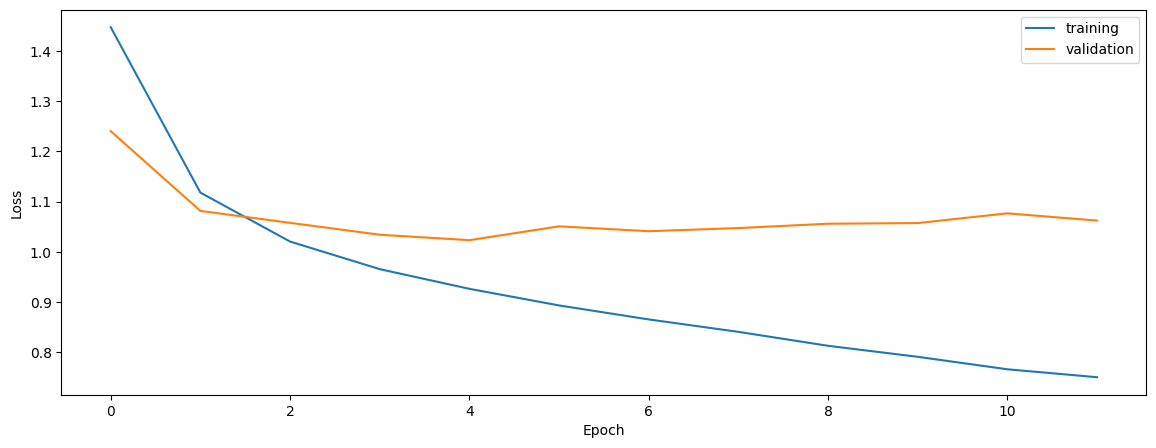

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.653703307284032
0.6109402897288789
0.5979758939295512


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.612134730734412
0.5996245508907593
0.5725111131000328


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6310027260001474
0.6159730722154223
0.6065970453387672


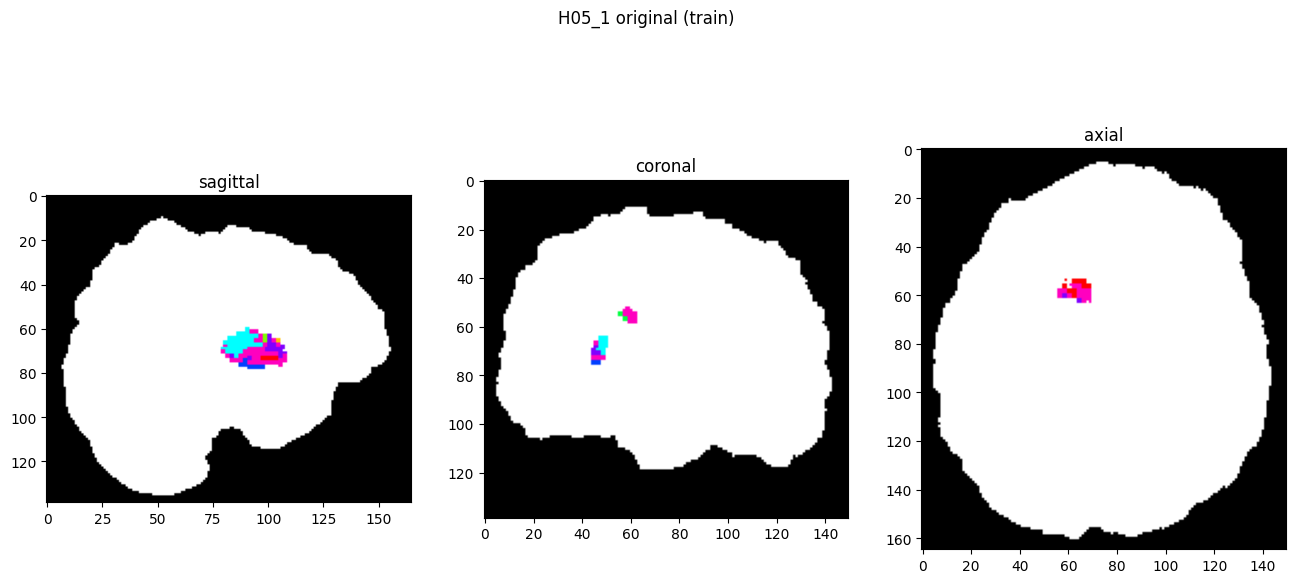

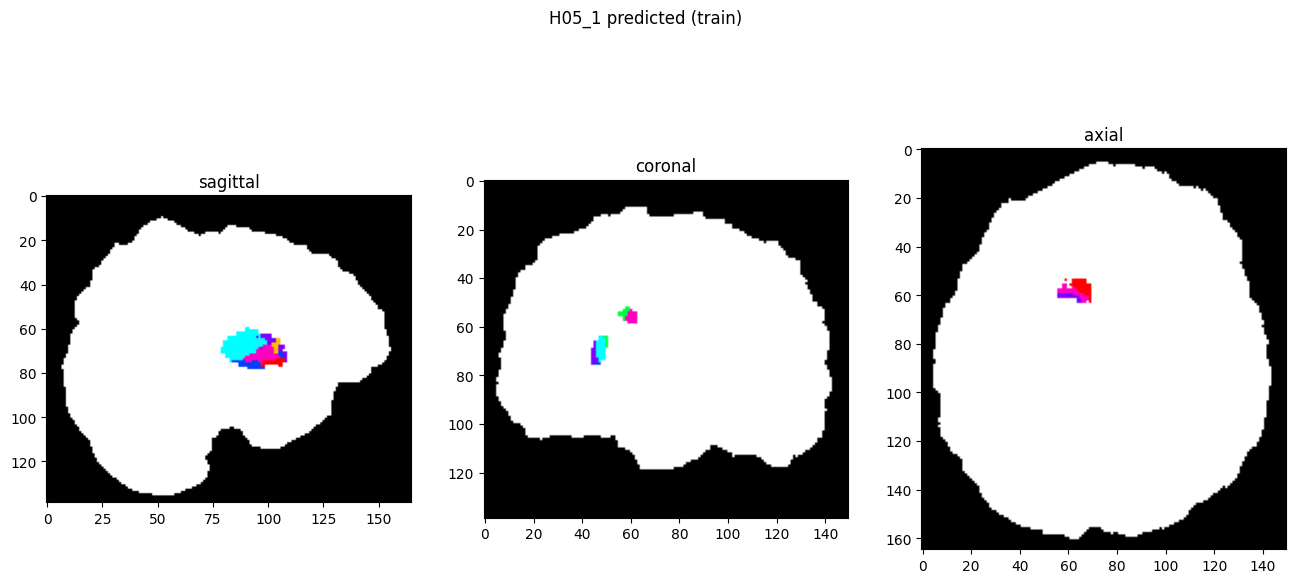

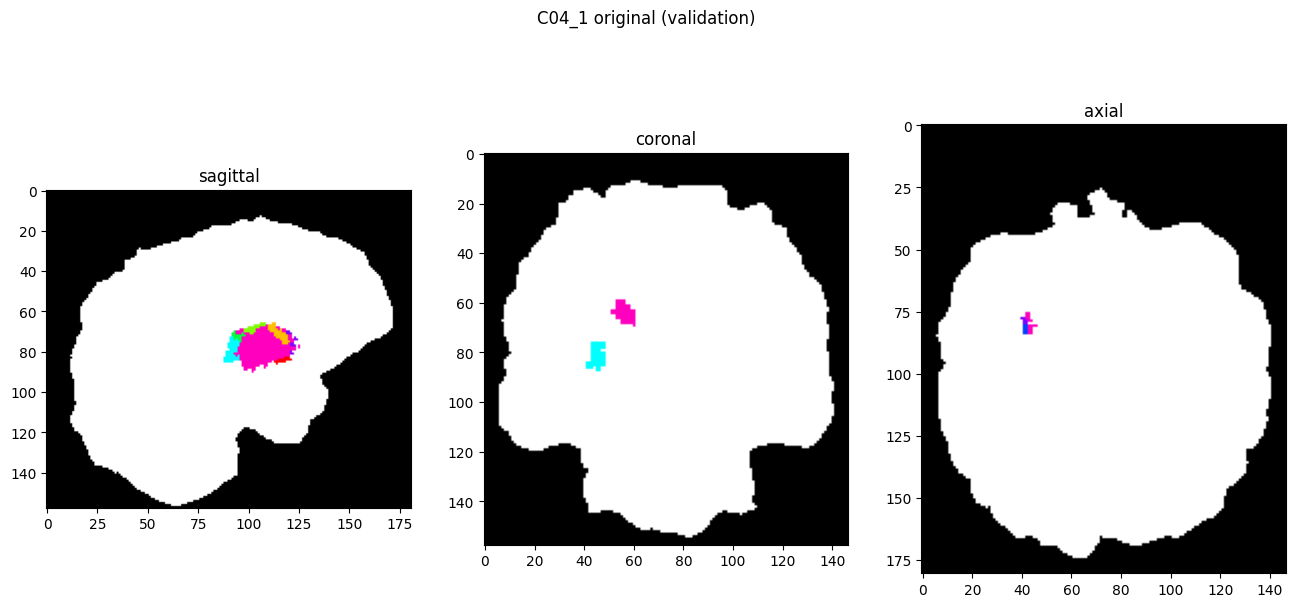

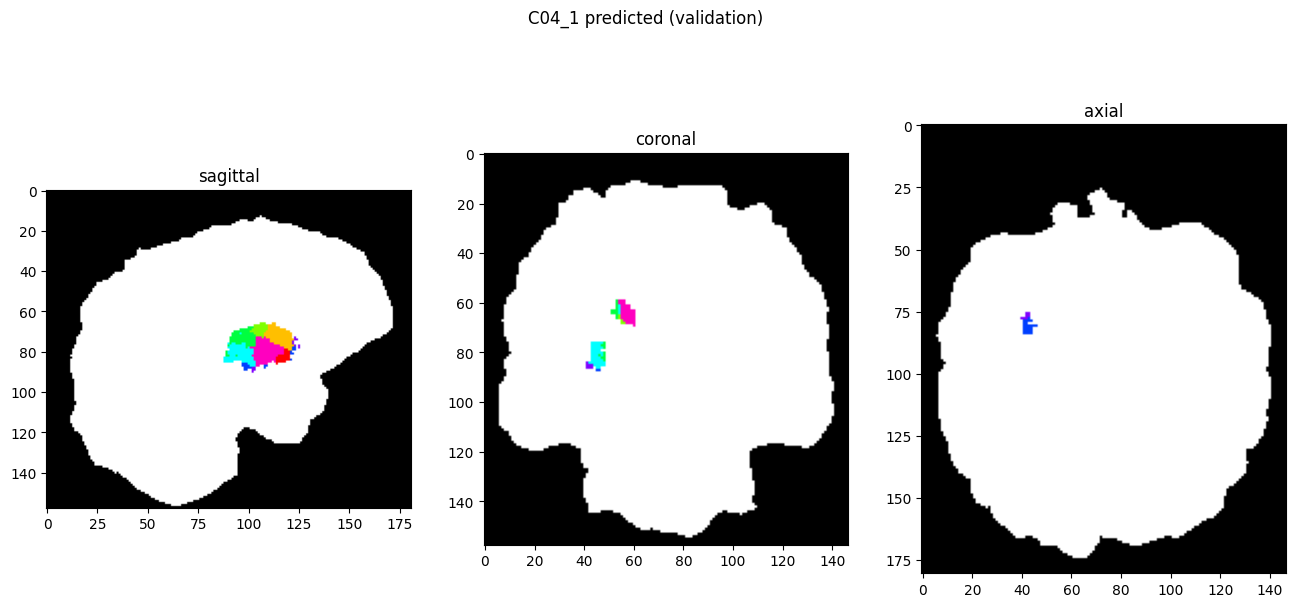

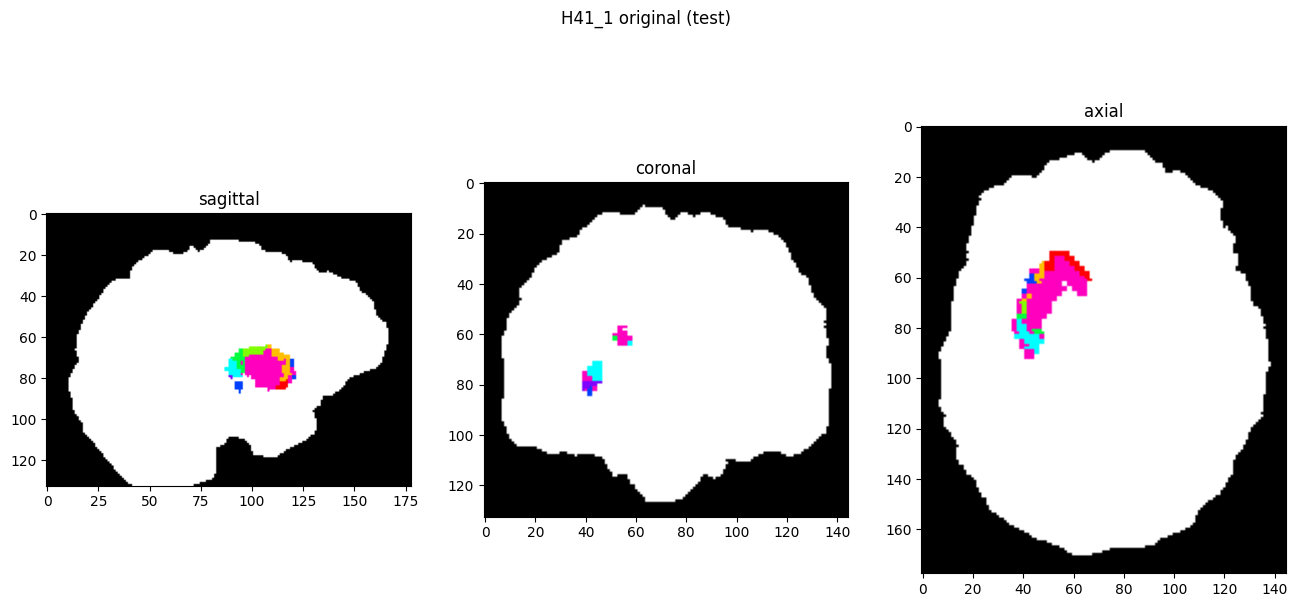

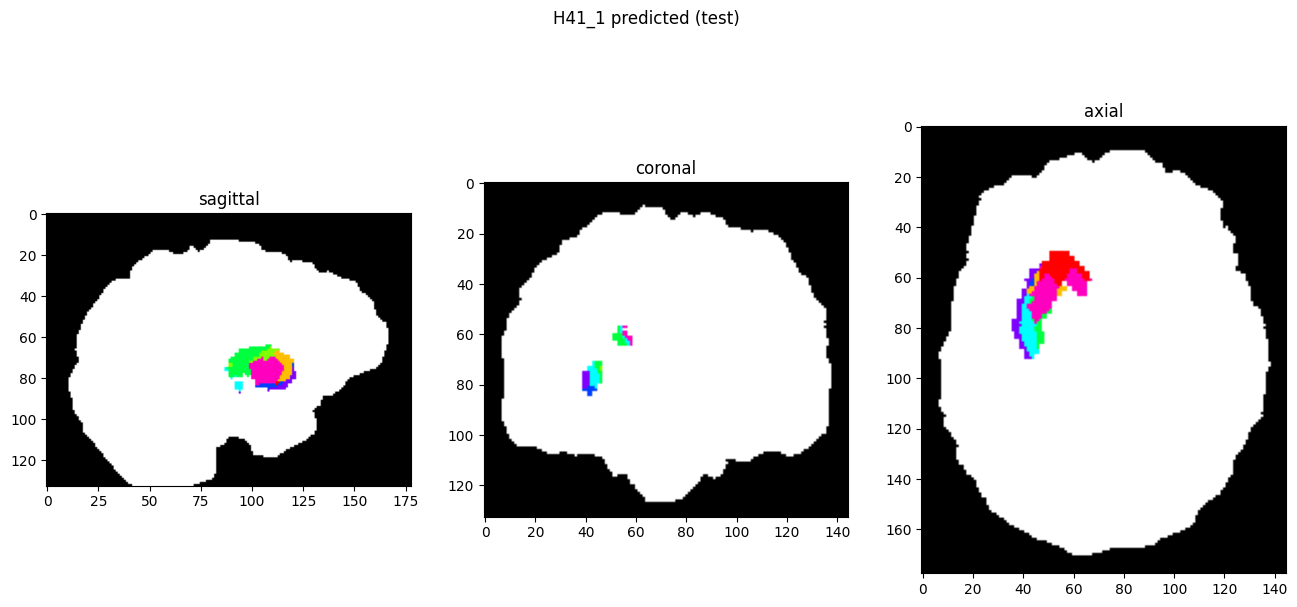

In [10]:
showResults(model, gen, threshold=0)